## Homework 3 - 602 Principles of Data Science

### Prepared by Ricardo Zambrano

In [84]:
import sqlite3
import pandas as pd
import numpy as np
import random
import requests
import urllib.request
import os
from bs4 import BeautifulSoup
from datetime import datetime, date, time
from datetime import timedelta
import re
import seaborn as sns
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
path = 'C:/Users/rzamb/Desktop/Desktop/UMD/Principles of Data Science/HW3'

In [5]:
file = 'lahmansbaseballdb.sqlite'

Once you establish a connection with the sqlite database, you can store query results directly in a pandas dataframe using the read_sql function. For example, here's how you would tabulate total league payrolls for each year:

In [6]:
sqlite_file = os.path.join(path,file)

In [7]:
conn = sqlite3.connect(sqlite_file)

salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"

team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


### The Question:

We want to understand how efficient teams have been historically at spending money and getting wins in return. In the case of Moneyball, one would expect that:

* Oakland was not much more efficient than other teams in their spending before 2000, 
* Were much more efficient (they made a movie about it after all) between 2000 and 2005 and, 
* By 2005 other teams may have caught up. Your job in this project is to see how this is reflected in the data we have.

### Part 1: Wrangling

The data you need to answer these questions is in the **Salaries** and **Teams** tables of the database.

#### Problem 1

Using SQL compute a relation containing the **total payroll** and **winning percentage (number of wins / number of games * 100)** for **each team (that is, for each teamID and yearID combination)**. You should include other columns that will help when performing EDA later on *(e.g., franchise ids, number of wins, number of games).*

Include the SQL code you used to create this relation in your writeup. **Describe how you dealt with any missing data** in these two relations. Specifically, **indicate if there is missing data in either table**, and **how the type of join you used determines how you dealt with this missing data**. One note, for SQL you have to be mindful of integer vs. float division.

**Ric wrote:** First I am going to find the tables inside the database

In [8]:
sql_query2 = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

In [9]:
cursor = conn.cursor()

In [10]:
cursor.execute(sql_query2)

In [11]:
print(cursor.fetchall())

[('allstarfull',), ('appearances',), ('awardsmanagers',), ('awardsplayers',), ('awardssharemanagers',), ('awardsshareplayers',), ('batting',), ('battingpost',), ('collegeplaying',), ('divisions',), ('fielding',), ('fieldingof',), ('fieldingofsplit',), ('fieldingpost',), ('halloffame',), ('homegames',), ('leagues',), ('managers',), ('managershalf',), ('parks',), ('people',), ('pitching',), ('pitchingpost',), ('salaries',), ('schools',), ('seriespost',), ('teams',), ('teamsfranchises',), ('teamshalf',)]


**Ric wrote:** The next step is to inspect the 'salaries' and 'teams' tables

In [12]:
sql_query3 = """SELECT *
            FROM salaries"""

In [13]:
cursor.execute(sql_query3)

In [14]:
pd.read_sql(sql_query3, conn).head()

,ID,yearID,teamID,team_ID,lgID,playerID,salary
0,1,1985,ATL,1918,NL,barkele01,870000.0
1,2,1985,ATL,1918,NL,bedrost01,550000.0
2,3,1985,ATL,1918,NL,benedbr01,545000.0
3,4,1985,ATL,1918,NL,campri01,633333.0
4,5,1985,ATL,1918,NL,ceronri01,625000.0


In [15]:
sql_query4 = """SELECT *
            FROM teams"""

In [16]:
pd.read_sql(sql_query4, conn).head()

,ID,yearID,lgID,teamID,franchID,divID,div_ID,teamRank,G,Ghome,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1,1871,NA,BS1,BNA,None,NaN,3,31,NaN,...,24,0.834,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,2,1871,NA,CH1,CNA,None,NaN,2,28,NaN,...,16,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,3,1871,NA,CL1,CFC,None,NaN,8,29,NaN,...,15,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,4,1871,NA,FW1,KEK,None,NaN,7,19,NaN,...,8,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,5,1871,NA,NY2,NNA,None,NaN,5,33,NaN,...,14,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [17]:
pd.read_sql(sql_query4, conn).columns

Index(['ID', 'yearID', 'lgID', 'teamID', 'franchID', 'divID', 'div_ID',
       'teamRank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin',
       'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF',
       'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA',
       'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF',
       'teamIDBR', 'teamIDlahman45', 'teamIDretro'],
      dtype='object')

**Ric wrote:** From the readme2021.txt available in the website below we learn that:
* G = Games played
* GHome = Games played at home
* W = Wins
* L = Losses
*source: https://www.seanlahman.com/files/database/readme2021.txt*

**Ric wrote:** With this statement I will start figuring out the basic queries. These will go as subqueries in the final query where I pull all the information all at one and store it in a python variable.

In [18]:
sql_query5 = """SELECT yearID,
             teamID,
             W as winGames,
             G as numGames,
             CAST(W as float)/CAST(G as float) as winPerc
             FROM teams;"""

**Ric wrote:** This statement is to find out if there are any missing values or zeros in the games column

In [19]:
set(pd.read_sql(sql_query5, conn).iloc[:,1])

{'ALT',
 'ANA',
 'ARI',
 'ATL',
 'BAL',
 'BFN',
 'BFP',
 'BL1',
 'BL2',
 'BL3',
 'BL4',
 'BLA',
 'BLF',
 'BLN',
 'BLU',
 'BOS',
 'BR1',
 'BR2',
 'BR3',
 'BR4',
 'BRF',
 'BRO',
 'BRP',
 'BS1',
 'BS2',
 'BSN',
 'BSP',
 'BSU',
 'BUF',
 'CAL',
 'CH1',
 'CH2',
 'CHA',
 'CHF',
 'CHN',
 'CHP',
 'CHU',
 'CIN',
 'CL1',
 'CL2',
 'CL3',
 'CL4',
 'CL5',
 'CL6',
 'CLE',
 'CLP',
 'CN1',
 'CN2',
 'CN3',
 'CNU',
 'COL',
 'DET',
 'DTN',
 'ELI',
 'FLO',
 'FW1',
 'HAR',
 'HOU',
 'HR1',
 'IN1',
 'IN2',
 'IN3',
 'IND',
 'KC1',
 'KC2',
 'KCA',
 'KCF',
 'KCN',
 'KCU',
 'KEO',
 'LAA',
 'LAN',
 'LS1',
 'LS2',
 'LS3',
 'MIA',
 'MID',
 'MIL',
 'MIN',
 'ML1',
 'ML2',
 'ML3',
 'ML4',
 'MLA',
 'MLU',
 'MON',
 'NEW',
 'NH1',
 'NY1',
 'NY2',
 'NY3',
 'NY4',
 'NYA',
 'NYN',
 'NYP',
 'OAK',
 'PH1',
 'PH2',
 'PH3',
 'PH4',
 'PHA',
 'PHI',
 'PHN',
 'PHP',
 'PHU',
 'PIT',
 'PRO',
 'PT1',
 'PTF',
 'PTP',
 'RC1',
 'RC2',
 'RIC',
 'SDN',
 'SE1',
 'SEA',
 'SFN',
 'SL1',
 'SL2',
 'SL3',
 'SL4',
 'SL5',
 'SLA',
 'SLF',
 'SLN',


In [20]:
sql_query6a = """SELECT G as numGames
             FROM teams
             WHERE W IS NULL;"""

In [21]:
cursor.execute(sql_query6a)

In [22]:
print(cursor.fetchall())

[]


In [23]:
pd.read_sql(sql_query5, conn)

,yearID,teamID,winGames,numGames,winPerc
0,1871,BS1,20,31,0.645161
1,1871,CH1,19,28,0.678571
2,1871,CL1,10,29,0.344828
3,1871,FW1,7,19,0.368421
4,1871,NY2,16,33,0.484848
...,...,...,...,...,...
2920,2019,SLN,91,162,0.561728
2921,2019,TBA,96,162,0.592593
2922,2019,TEX,78,162,0.481481
2923,2019,TOR,67,162,0.413580


In [24]:
sql_query7 = """SELECT yearID, 
            teamID,
            SUM(salary) AS payroll
            FROM salaries
            GROUP BY teamID,yearID;"""

In [25]:
pd.read_sql(sql_query7, conn)

,yearID,teamID,payroll
0,1985,ATL,14807000.0
1,1985,BAL,11560712.0
2,1985,BOS,10897560.0
3,1985,CAL,14427894.0
4,1985,CHA,9846178.0
...,...,...,...
913,2016,SLN,143053500.0
914,2016,TBA,57097310.0
915,2016,TEX,176038723.0
916,2016,TOR,138701700.0


**Ric wrote:** The payroll data goes from 1985 to 2016. The teams table goes from 1871 to 2019. I will do an inner join the salaries table with the teams table in order to keep only the rows recorded in the salaries table. 

**Ric wrote:** Below is the master SQL query that generates the data we need to answer part one. After testing I close the connection wiith the database.

In [26]:
sql_query8 = """SELECT pr.yearID, 
            pr.teamID,
            pr.payroll,
            tms.winPerc
            FROM
            (SELECT yearID, 
            teamID,
            SUM(salary) AS payroll
            FROM salaries
            GROUP BY teamID,yearID) AS pr
            INNER JOIN 
            (SELECT yearID,
             teamID,
             W as winGames,
             G as numGames,
             CAST(W as float)/CAST(G as float) as winPerc
             FROM teams
            ) AS tms
            ON pr.teamID = tms.teamID
            AND pr.yearID = tms.yearID;"""

In [27]:
part1 = pd.read_sql(sql_query8, conn)
part1

,yearID,teamID,payroll,winPerc
0,1985,ATL,14807000.0,0.407407
1,1985,BAL,11560712.0,0.515528
2,1985,BOS,10897560.0,0.496933
3,1985,CAL,14427894.0,0.555556
4,1985,CHA,9846178.0,0.521472
...,...,...,...,...
913,2016,SLN,143053500.0,0.530864
914,2016,TBA,57097310.0,0.419753
915,2016,TEX,176038723.0,0.586420
916,2016,TOR,138701700.0,0.549383


**Ric wrote:** The following statement is to verify that the join went well, by observing there is variation in every year for one team in the two variables of interest: payroll and winPerc. It is a weak test, I know, but time constraints allow me to go only this far.

In [28]:
# After checking the complete set I reduced to the first five rows to save space in the submission
part1[part1['teamID']=='ATL'].head(5)

,yearID,teamID,payroll,winPerc
0,1985,ATL,14807000.0,0.407407
26,1986,ATL,17102786.0,0.447205
52,1987,ATL,16544560.0,0.428571
78,1988,ATL,12728174.0,0.337500
104,1989,ATL,11112334.0,0.391304


In [158]:
conn.close()

### Part 2: Exploratory Data Analysis

#### Payroll Distribution

#### Problem 2
Write code to produce plots that illustrate the distribution of payrolls across teams conditioned on time (from 1990-2014).

In [29]:
part1_90to14 = part1[(part1['yearID']>1989) & (part1['yearID']<2015)]

In [30]:
uniqueTeams = list(set(part1_90to14['teamID']))

**Ric wrote:** I will have to add a legend manually. Thereby, I am creating a color dictionary which then I maap to the labels in order to build the legend.

In [31]:
color = cm.rainbow(np.linspace(0, 1, len(uniqueTeams)))
type(color)

numpy.ndarray

In [32]:
colorDict = {uniqueTeams[i]: color[i] for i in range(len(color))}

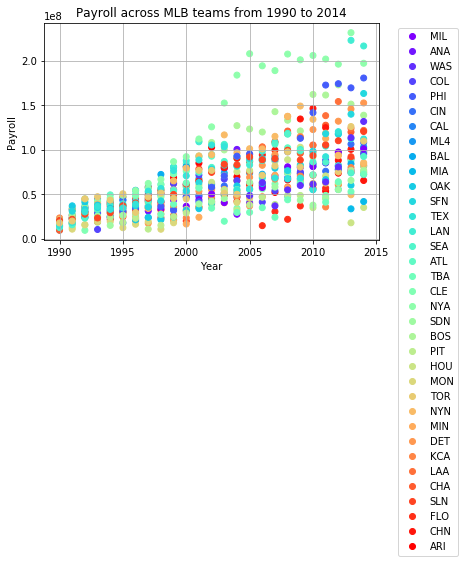

In [33]:
fig1 = plt.figure()

plt.scatter(part1_90to14['yearID'],part1_90to14['payroll'],
            c=part1_90to14['teamID'].map(colorDict))
legendhandle = [plt.plot([], marker="o", ls="", 
                         color=color)[0] for color in list(colorDict.values())]
plt.legend(legendhandle,list(colorDict.keys()),loc="upper right", frameon=True,
          bbox_to_anchor=(1.25, 1.0))
plt.title("Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Year")
plt.ylabel("Payroll")
plt.grid()
plt.show()

#### Question 1

What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

**Ric wrote:** The spread of payroll increases over time

#### Problem 3

Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

In [34]:
yearPayroll = part1_90to14.groupby(["yearID"])["payroll"].describe()
yearPayroll.head(5)

,count,mean,std,min,25%,50%,75%,max
yearID,,,,,,,,
1990,26.0,1.707235e+07,3.771834e+06,9491500.0,14504125.25,17590786.0,20364375.75,23361084.0
1991,26.0,2.357879e+07,6.894669e+06,10732333.0,18269250.00,23145583.5,27088084.50,36999167.0
1992,26.0,3.098244e+07,9.150607e+06,9373044.0,26971333.75,30587250.0,35635957.75,44788666.0
1993,28.0,3.220500e+07,9.232485e+06,10353500.0,25339116.50,33873166.5,39345665.75,47279166.0
1994,28.0,3.313701e+07,8.528749e+06,14916333.0,27617929.50,33049798.5,39523210.50,49383513.0


In [35]:
# To add a trend line to the plot
z = np.polyfit(yearPayroll.index,yearPayroll['std'],1)
p = np.poly1d(z)

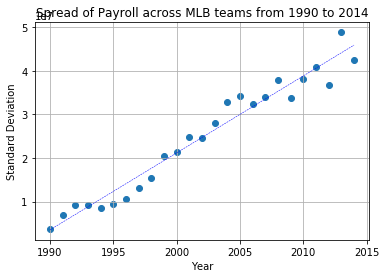

In [36]:
fig2 = plt.figure()

plt.scatter(yearPayroll.index,yearPayroll['std'])
#plt.legend()
plt.title("Spread of Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Year")
plt.ylabel("Standard Deviation")
plt.plot(yearPayroll.index, p(yearPayroll.index), color="blue", linewidth=0.5, linestyle="--")
plt.grid()
plt.show()

**Ric wrote:** This plot confirms the spread increases over the years. I added a trend line to enphaseze this point.

#### Correlation between payroll and winning percentage

#### Problem 4

Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's polyfit) in each scatter plot to ease interpretation.

In [37]:
part1_90to14.tail(5)

,yearID,teamID,payroll,winPerc
853,2014,SLN,120693000.0,0.555556
854,2014,TBA,72689100.0,0.475309
855,2014,TEX,112255059.0,0.413580
856,2014,TOR,109920100.0,0.512346
857,2014,WAS,131983680.0,0.592593


**Ric wrote:** To use pd.cut I need to create the bins. Then with pd.cut I create the year cut column.

In [38]:
binLabls = ['90-94','95-99','00-04','05-09','10-14']
yrbins = [1989,1994,1999,2004,2009,2014] 
part1_90to14['yearCut'] = pd.cut(part1_90to14['yearID'],bins=yrbins,labels=binLabls)

C:\Users\rzamb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
part1_90to14

,yearID,teamID,payroll,winPerc,yearCut
130,1990,ATL,14555501.0,0.401235,90-94
131,1990,BAL,9680084.0,0.472050,90-94
132,1990,BOS,20558333.0,0.543210,90-94
133,1990,CAL,21720000.0,0.493827,90-94
134,1990,CHA,9491500.0,0.580247,90-94
...,...,...,...,...,...
853,2014,SLN,120693000.0,0.555556,10-14
854,2014,TBA,72689100.0,0.475309,10-14
855,2014,TEX,112255059.0,0.413580,10-14
856,2014,TOR,109920100.0,0.512346,10-14


**Ric wrote:** By using groupby(), the yearCut label, and agg() I can calculate the payroollMean for the discrete five-year periods. Then I will do the same for winPerc.

In [40]:
payrollDiscr = part1_90to14.groupby('yearCut', as_index=False)['payroll'].agg([list, 'mean'])
payrollDiscr.columns = ['payrollObs', 'payrollMean']
payrollDiscr

,payrollObs,payrollMean
yearCut,,
90-94,"[14555501.0, 9680084.0, 20558333.0, 21720000.0...",2.755261e+07
95-99,"[47235445.0, 43942521.0, 32455518.0, 31223171....",4.033507e+07
00-04,"[51464167.0, 81027833.0, 84537836.0, 81447435....",6.566536e+07
05-09,"[62329166.0, 86457302.0, 73914333.0, 123505125...",8.224307e+07
10-14,"[60718166.0, 84423666.0, 81612500.0, 162447333...",9.776966e+07


In [41]:
winPercDiscr = part1_90to14.groupby('yearCut', as_index=False)['winPerc'].agg([list, 'mean'])
winPercDiscr.columns = ['winPercObs', 'winPercMean']
winPercDiscr

,winPercObs,winPercMean
yearCut,,
90-94,"[0.4012345679012346, 0.4720496894409938, 0.543...",0.499927
95-99,"[0.625, 0.4930555555555556, 0.5972222222222222...",0.499736
00-04,"[0.5061728395061729, 0.5246913580246914, 0.586...",0.499827
05-09,"[0.47530864197530864, 0.5555555555555556, 0.45...",0.499941
10-14,"[0.4012345679012346, 0.5617283950617284, 0.407...",0.499995


In [159]:
# To add a trend line to the plot
# I am not using these most of the time because they did not seem to work for certain series.
# Instead I used seaborn to add a trend line for the other series below.
z2 = np.polyfit(payrollDiscr['payrollMean'],winPercDiscr['winPercMean'],1)
p2 = np.poly1d(z2)

**Ric wrote:** I commented out the title of the plot because it was in the way. It made obstructed part of the plot.

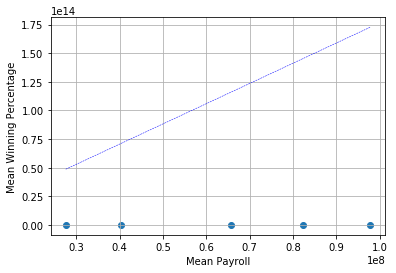

In [43]:
fig3 = plt.figure()

plt.scatter(payrollDiscr['payrollMean'],winPercDiscr['winPercMean'])
#plt.legend()
#plt.title("Avg. Winning Percentage vs. Avg. Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Mean Payroll")
plt.ylabel("Mean Winning Percentage")
plt.plot(payrollDiscr['payrollMean'], p(payrollDiscr['payrollMean']), color="blue", 
         linewidth=0.5, linestyle="--")
plt.grid()
plt.show()

**Ric wrote:** Since np.polyfit did not seem to worked I will try with seaborn regplot

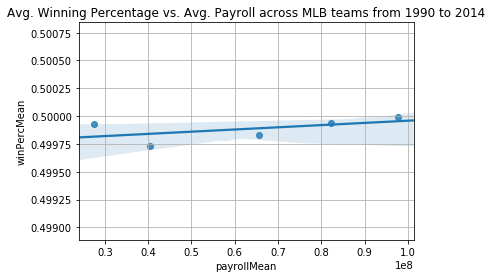

In [105]:
fig3b = sns.regplot(x=payrollDiscr['payrollMean'],y=winPercDiscr['winPercMean'])
plt.title('Avg. Winning Percentage vs. Avg. Payroll across MLB teams from 1990 to 2014')
plt.grid()

In [44]:
listOfTup = list(zip(payrollDiscr['payrollMean'],winPercDiscr['winPercMean']))
sumTable = pd.DataFrame(listOfTup,
              columns = ['payrollMean','winPercMean'],
              index = payrollDiscr.index)
sumTable

,payrollMean,winPercMean
yearCut,,
90-94,2.755261e+07,0.499927
95-99,4.033507e+07,0.499736
00-04,6.566536e+07,0.499827
05-09,8.224307e+07,0.499941
10-14,9.776966e+07,0.499995


**Ric wrote:** On the blocks above I grouped by yearCut across all MBL teams. However, we need to be able to see the data by team. Thereby, here I repeat similar steps, this time I group first by tean and then for each team by yearCut (the five year periods). 

In [45]:
payrollDiscr2 = part1_90to14.groupby(['teamID','yearCut'], as_index=False)['payroll'].agg([list, 'mean'])
payrollDiscr2.columns = ['payrollObs', 'payrollMean']
payrollDiscr2

payrollObs  payrollMean
teamID yearCut                                                                
ANA    90-94                                                  NaN          NaN
       95-99                 [31135472.0, 41281000.0, 55388166.0]   42601546.0
       00-04    [51464167.0, 47535167.0, 61721667.0, 79031667....   68057467.0
       05-09                                                  NaN          NaN
       10-14                                                  NaN          NaN
...                                                           ...          ...
WAS    90-94                                                  NaN          NaN
       95-99                                                  NaN          NaN
       00-04                                                  NaN          NaN
       05-09    [48581500.0, 63143000.0, 36947500.0, 54961000....   52712200.0
       10-14    [61400000.0, 63856928.0, 80855143.0, 113703270...   90359804.2

[175 rows x 2 columns]

In [46]:
winPercDiscr2 = part1_90to14.groupby(['teamID','yearCut'], as_index=False)['winPerc'].agg([list, 'mean'])
winPercDiscr2.columns = ['winPercObs', 'winPercMean']
winPercDiscr2

winPercObs  winPercMean
teamID yearCut                                                                
ANA    90-94                                                  NaN          NaN
       95-99    [0.5185185185185185, 0.5246913580246914, 0.432...     0.491770
       00-04    [0.5061728395061729, 0.46296296296296297, 0.61...     0.524691
       05-09                                                  NaN          NaN
       10-14                                                  NaN          NaN
...                                                           ...          ...
WAS    90-94                                                  NaN          NaN
       95-99                                                  NaN          NaN
       00-04                                                  NaN          NaN
       05-09    [0.5, 0.4382716049382716, 0.4506172839506173, ...     0.423909
       10-14    [0.42592592592592593, 0.4968944099378882, 0.60...     0.530243

[175 rows x 2 columns]

In [47]:
listOfTup2 = list(zip(payrollDiscr2['payrollMean'],winPercDiscr2['winPercMean']))
sumTable2 = pd.DataFrame(listOfTup2,
              columns = ['payrollMean','winPercMean'],
              index = payrollDiscr2.index)
sumTable2

payrollMean  winPercMean
teamID yearCut                          
ANA    90-94            NaN          NaN
       95-99     42601546.0     0.491770
       00-04     68057467.0     0.524691
       05-09            NaN          NaN
       10-14            NaN          NaN
...                     ...          ...
WAS    90-94            NaN          NaN
       95-99            NaN          NaN
       00-04            NaN          NaN
       05-09     52712200.0     0.423909
       10-14     90359804.2     0.530243

[175 rows x 2 columns]

**Ric wrote:** There are several five-year period rows with np.nan values. In order to be able to compute plots and new variables easily we need to discard the np.nan values. In order to create that I create a mask and then I filter by using the data mask.

In [48]:
# To create a mask to filter np.nan
maskPayr = np.isfinite(sumTable2['payrollMean'])
maskWPerc = np.isfinite(sumTable2['winPercMean'])

**Ric wrote:** Here I will create labels that I can use later for plots. I will add this labels as a column to the masked dataframe.

In [49]:
sumTable2.index[maskPayr][0][0] + '/' + sumTable2.index[maskPayr][0][1]

'ANA/95-99'

In [50]:
legLabels = [sumTable2.index[maskPayr][i][0] + '/' + sumTable2.index[maskPayr][i][1] for i in range(len(sumTable2.index[maskPayr]))]
legLabels

['ANA/95-99',
 'ANA/00-04',
 'ARI/95-99',
 'ARI/00-04',
 'ARI/05-09',
 'ARI/10-14',
 'ATL/90-94',
 'ATL/95-99',
 'ATL/00-04',
 'ATL/05-09',
 'ATL/10-14',
 'BAL/90-94',
 'BAL/95-99',
 'BAL/00-04',
 'BAL/05-09',
 'BAL/10-14',
 'BOS/90-94',
 'BOS/95-99',
 'BOS/00-04',
 'BOS/05-09',
 'BOS/10-14',
 'CAL/90-94',
 'CAL/95-99',
 'CHA/90-94',
 'CHA/95-99',
 'CHA/00-04',
 'CHA/05-09',
 'CHA/10-14',
 'CHN/90-94',
 'CHN/95-99',
 'CHN/00-04',
 'CHN/05-09',
 'CHN/10-14',
 'CIN/90-94',
 'CIN/95-99',
 'CIN/00-04',
 'CIN/05-09',
 'CIN/10-14',
 'CLE/90-94',
 'CLE/95-99',
 'CLE/00-04',
 'CLE/05-09',
 'CLE/10-14',
 'COL/90-94',
 'COL/95-99',
 'COL/00-04',
 'COL/05-09',
 'COL/10-14',
 'DET/90-94',
 'DET/95-99',
 'DET/00-04',
 'DET/05-09',
 'DET/10-14',
 'FLO/90-94',
 'FLO/95-99',
 'FLO/00-04',
 'FLO/05-09',
 'FLO/10-14',
 'HOU/90-94',
 'HOU/95-99',
 'HOU/00-04',
 'HOU/05-09',
 'HOU/10-14',
 'KCA/90-94',
 'KCA/95-99',
 'KCA/00-04',
 'KCA/05-09',
 'KCA/10-14',
 'LAA/05-09',
 'LAA/10-14',
 'LAN/90-94',
 'LAN/

In [51]:
sumTable2Masked = pd.DataFrame().assign(
    payrollMean = sumTable2['payrollMean'][maskPayr], 
    winPercMean = sumTable2['winPercMean'][maskWPerc],
    legendLabels = legLabels)

In [52]:
sumTable2Masked.head(5)

payrollMean  winPercMean legendLabels
teamID yearCut                                       
ANA    95-99     42601546.0     0.491770    ANA/95-99
       00-04     68057467.0     0.524691    ANA/00-04
ARI    95-99     50525499.5     0.509259    ARI/95-99
       00-04     83873716.2     0.506173    ARI/00-04
       05-09     62679863.2     0.487654    ARI/05-09

**Ric wrote:** I am creating a color dictionary to map to labels. I will repeat this sevral times.

In [53]:
color2 = cm.rainbow(np.linspace(0, 1, len(sumTable2Masked['legendLabels'])))

In [54]:
colorDict2 = {sumTable2Masked['legendLabels'][i]: color2[i] for i in range(len(color2))}

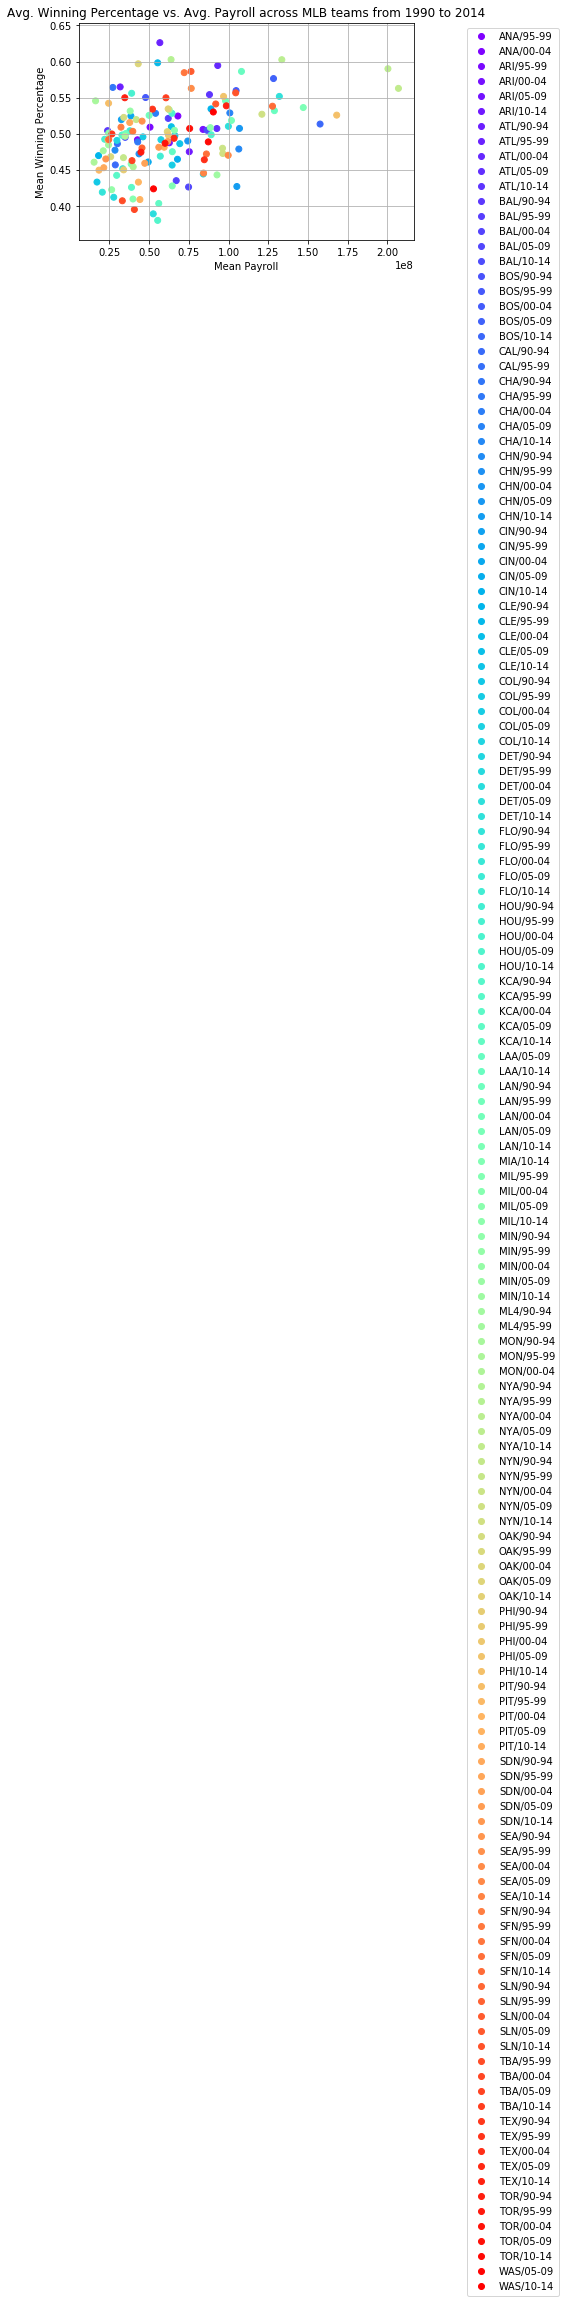

In [55]:
fig4 = plt.figure()

plt.scatter(sumTable2Masked['payrollMean'],sumTable2Masked['winPercMean'],
            c=sumTable2Masked['legendLabels'].map(colorDict2))
legendhandle2 = [plt.plot([], marker="o", ls="", 
                         color=color)[0] for color in list(colorDict2.values())]
plt.legend(legendhandle2,list(colorDict2.keys()),loc="upper right", frameon=True,
          bbox_to_anchor=(1.45, 1.0))
plt.title("Avg. Winning Percentage vs. Avg. Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Mean Payroll")
plt.ylabel("Mean Winning Percentage")
plt.grid()
plt.show()

**Ric wrote:** It seems that the homework requires us to plot individual plots for each team. I am going to do this in the following blocks of code. However, for annotations I will plot them all together.

**Ric wrote:** The code below unzips the table index and then it creates a list of unique teams. i will use these unique teams list in order to iterate in the table and produce unique plots for each team.

In [56]:
teamRows,*_ = [list(t) for t in zip(*sumTable2Masked.index)]

In [57]:
uniqueTeams = list(set(teamRows))
uniqueTeams

['MIL',
 'ANA',
 'WAS',
 'COL',
 'PHI',
 'CIN',
 'CAL',
 'ML4',
 'BAL',
 'MIA',
 'OAK',
 'SFN',
 'TEX',
 'LAN',
 'SEA',
 'ATL',
 'TBA',
 'CLE',
 'NYA',
 'SDN',
 'BOS',
 'HOU',
 'PIT',
 'MON',
 'TOR',
 'NYN',
 'MIN',
 'DET',
 'KCA',
 'LAA',
 'CHA',
 'FLO',
 'SLN',
 'CHN',
 'ARI']

In [58]:
sumTable2Masked.loc[uniqueTeams[0]]['payrollMean'].values

array([38646149.5, 39767099.8, 65921933.4, 88484717.6])

In [59]:
colorS = cm.rainbow(np.linspace(0, 1, len(uniqueTeams)))

In [60]:
colorDictS = {uniqueTeams[i]: colorS[i] for i in range(len(colorS))}

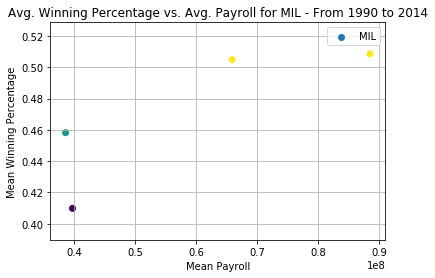

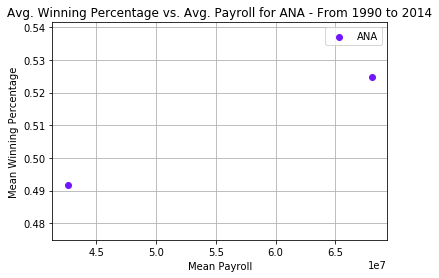

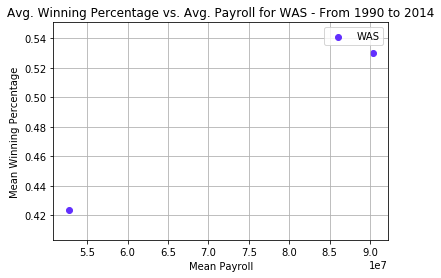

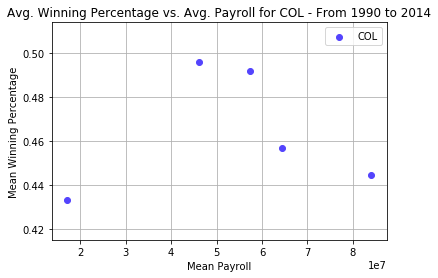

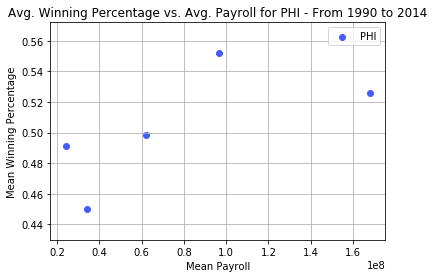

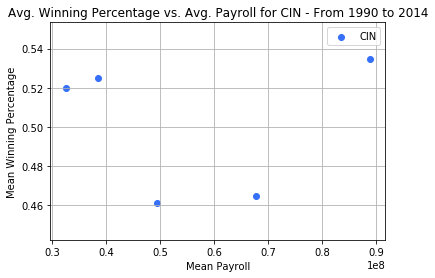

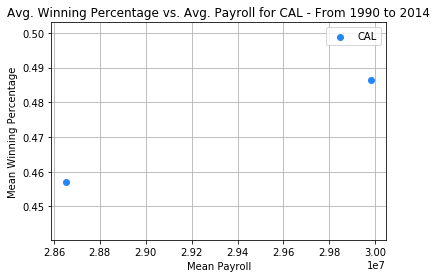

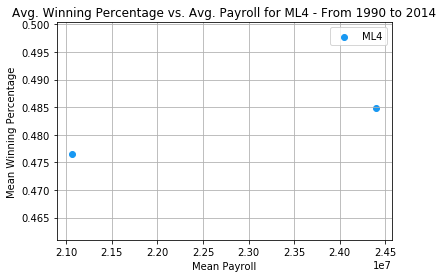

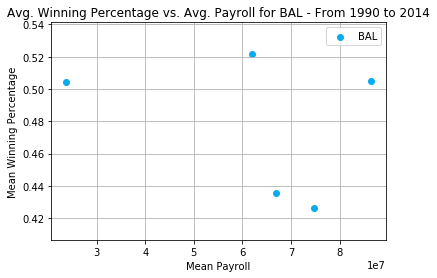

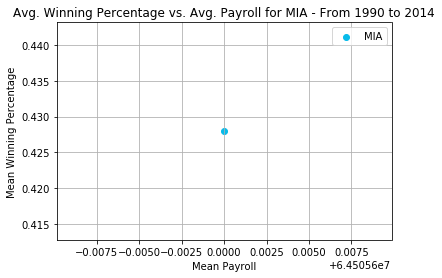

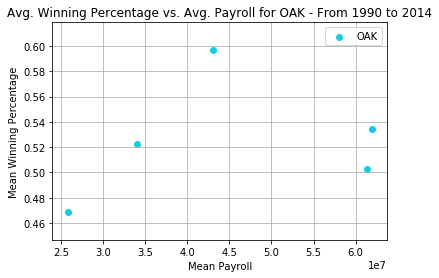

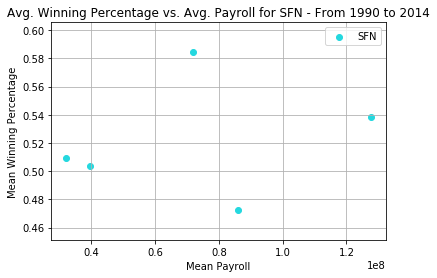

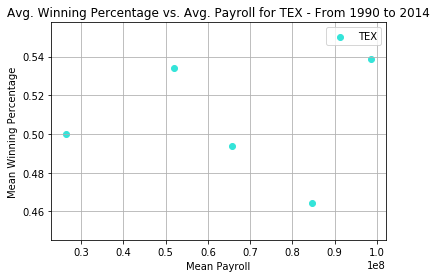

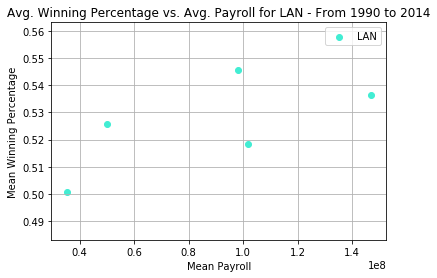

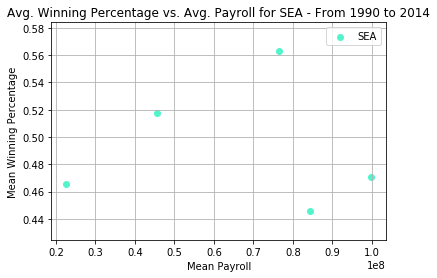

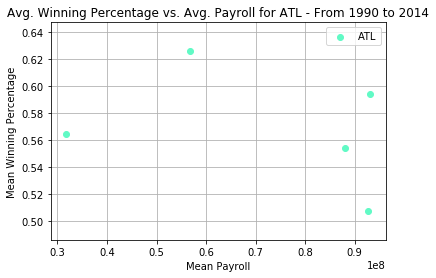

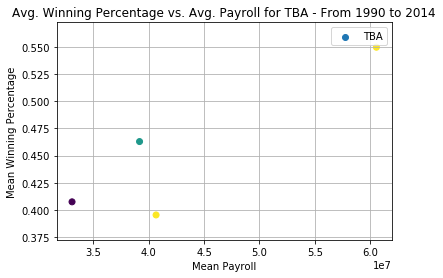

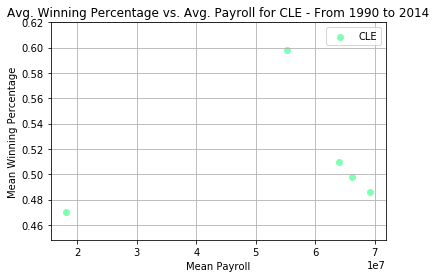

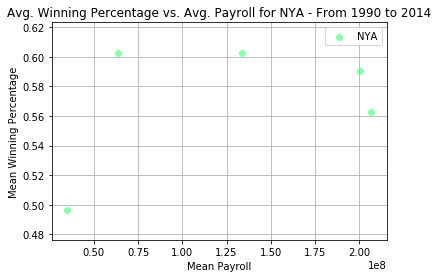

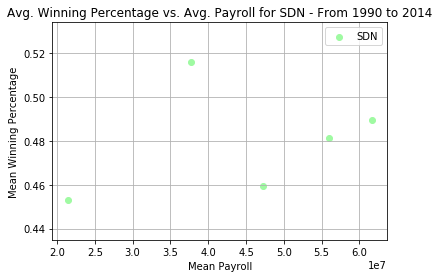

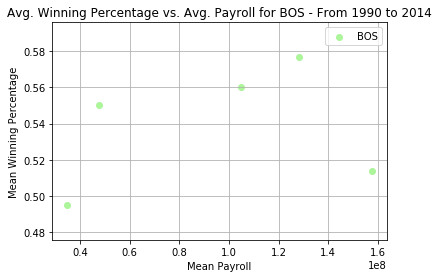

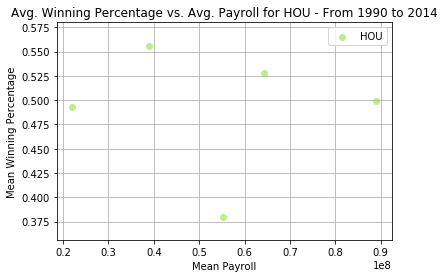

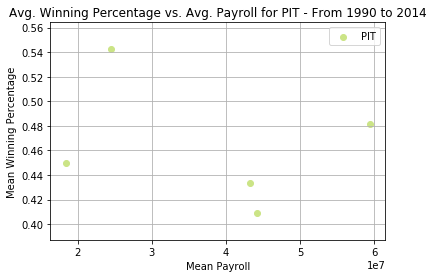

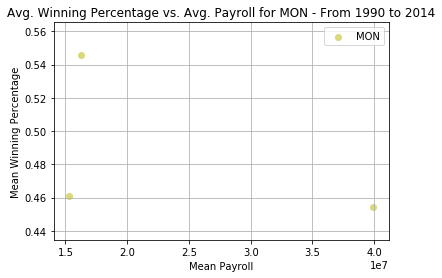

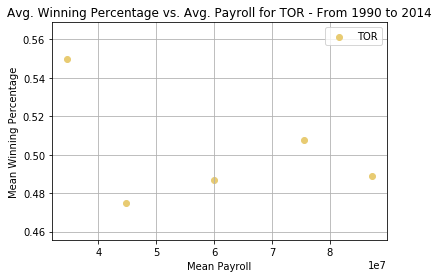

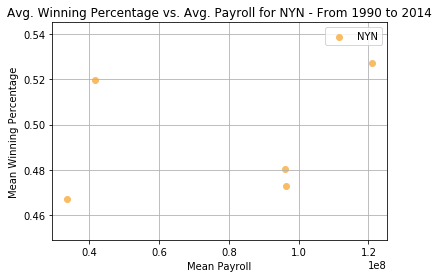

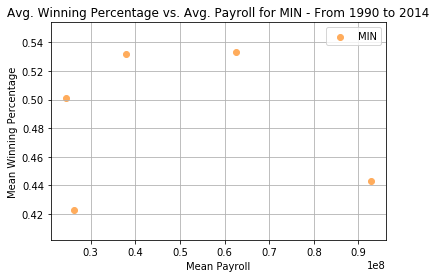

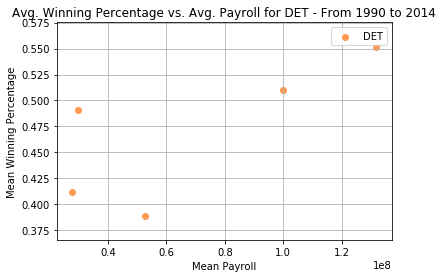

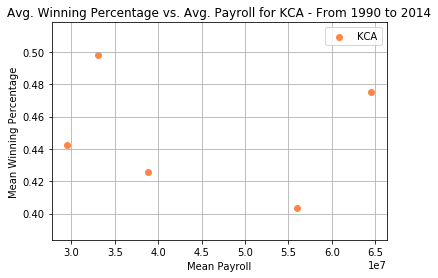

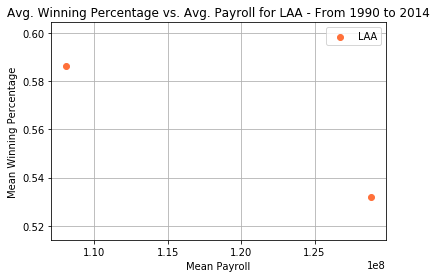

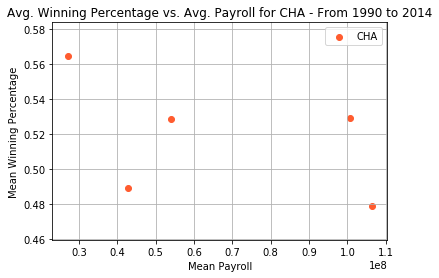

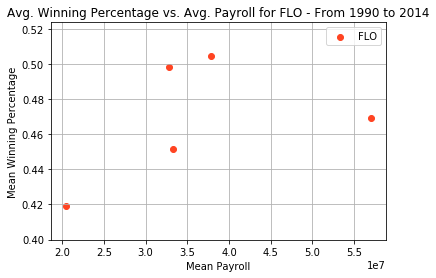

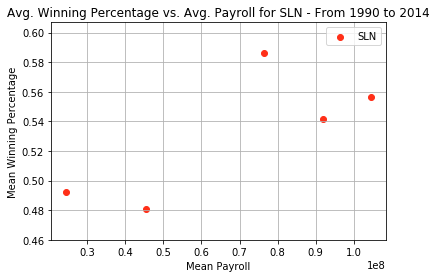

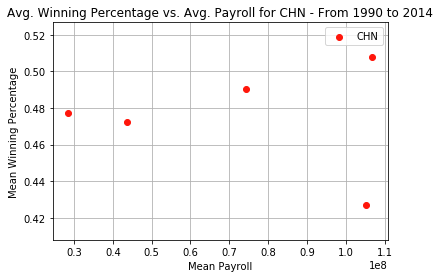

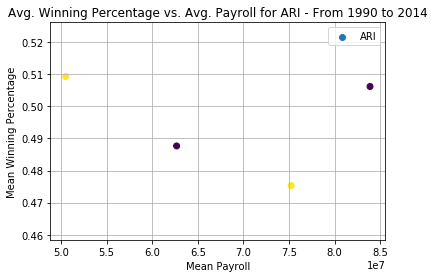

In [61]:
for i in range(len(uniqueTeams)):
#    zz = np.polyfit(sumTable2Masked.loc[uniqueTeams[i]]['payrollMean'].values,
#                sumTable2Masked.loc[uniqueTeams[i]]['winPercMean'].values,1)
#    pp = np.poly1d(zz)

    plt.scatter(sumTable2Masked.loc[uniqueTeams[i]]['payrollMean'],
            sumTable2Masked.loc[uniqueTeams[i]]['winPercMean'],
            c=colorS[i],label=uniqueTeams[i])
#         plt.plot(sumTable2Masked.loc[uniqueTeams[i]]['payrollMean'].values, 
#         p(sumTable2Masked.loc[uniqueTeams[i]]['payrollMean'].values),
#         color=colorS[i], 
#         linewidth=0.5, linestyle="-")
    plt.legend()
    plt.title("Avg. Winning Percentage vs. Avg. Payroll for {} - From 1990 to 2014".format(uniqueTeams[i]))
    plt.xlabel("Mean Payroll")
    plt.ylabel("Mean Winning Percentage")
    plt.grid()
    plt.show()

**Ric wrote:** i am interested in finfind the best performers in the dataset. I am choosing the teams with the higher winPercMean.

In [62]:
top5 = sumTable2Masked.sort_values(by=['winPercMean'],ascending=False).head(5)
top5

payrollMean  winPercMean legendLabels
teamID yearCut                                       
ATL    95-99     56707689.0     0.626235    ATL/95-99
NYA    95-99     63769882.8     0.602793    NYA/95-99
       00-04    133499550.0     0.602655    NYA/00-04
CLE    95-99     55325256.6     0.598332    CLE/95-99
OAK    00-04     43094550.2     0.596994    OAK/00-04

**Ric wrote:** This code calculates the coordinates of the annotations. I will later add a random amount of displacement to each coordinate in order to avoid overlaping of the annotations.

In [63]:
top5coord = zip(top5['payrollMean'].values,top5['winPercMean'].values,top5['legendLabels'].values)
top5coord

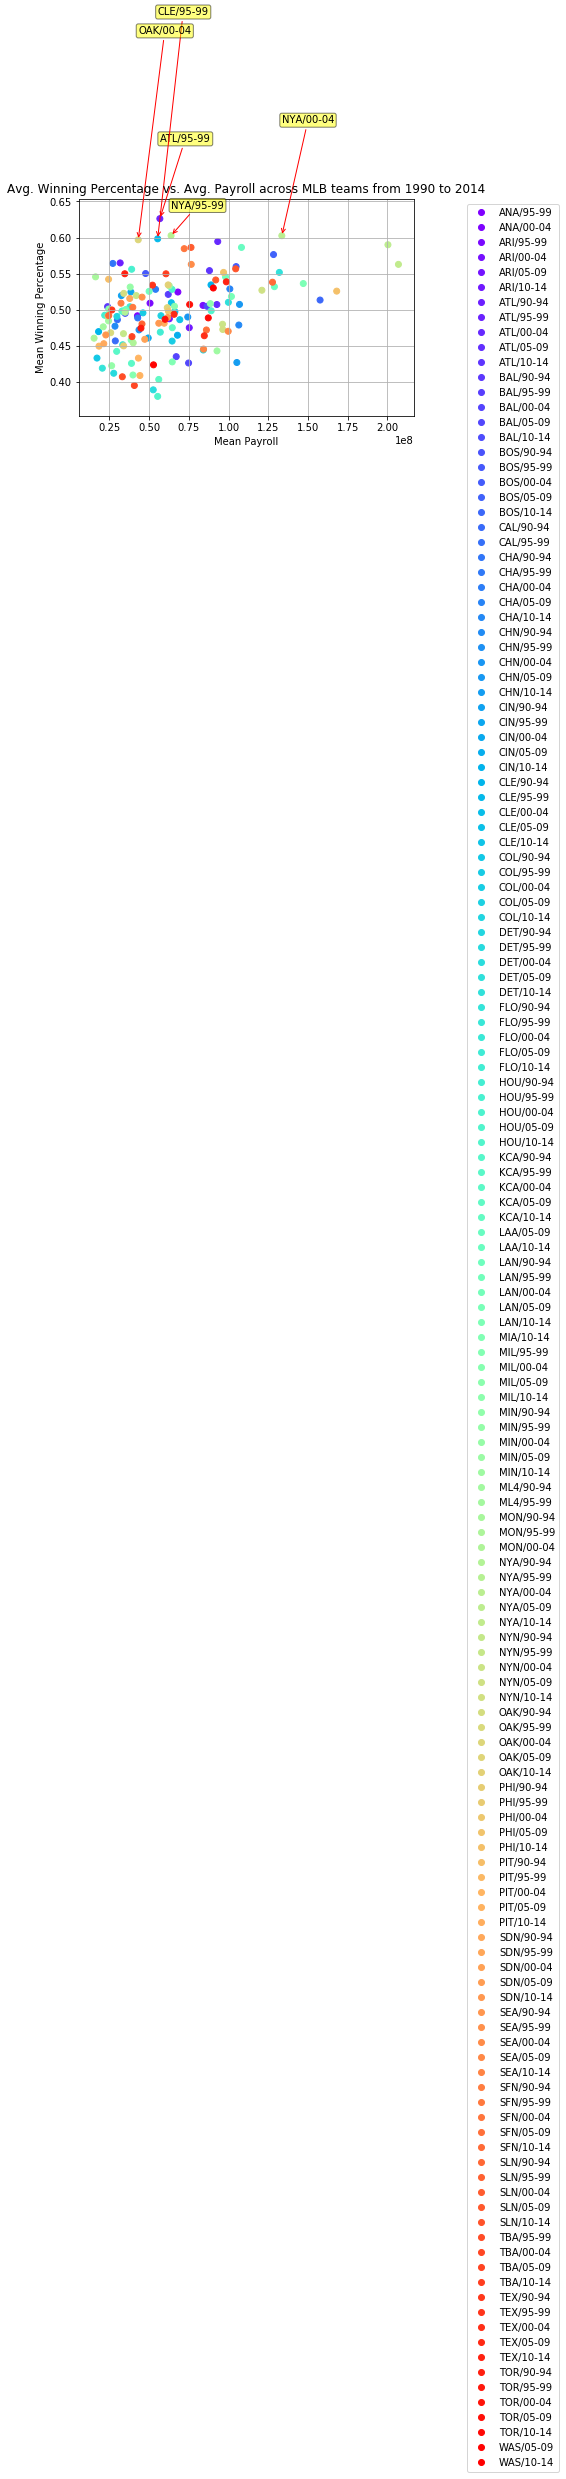

In [64]:
fig5 = plt.figure()

plt.scatter(sumTable2Masked['payrollMean'],sumTable2Masked['winPercMean'],
            c=sumTable2Masked['legendLabels'].map(colorDict2))
legendhandle2 = [plt.plot([], marker="o", ls="", 
                         color=color)[0] for color in list(colorDict2.values())]
plt.legend(legendhandle2,list(colorDict2.keys()),loc="upper right", frameon=True,
          bbox_to_anchor=(1.45, 1.0))
plt.title("Avg. Winning Percentage vs. Avg. Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Mean Payroll")
plt.ylabel("Mean Winning Percentage")

for payroll, winperc, label in top5coord:
    plt.annotate(label,xy=(payroll, winperc),xytext=(payroll, winperc+random.random()/3),
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            #horizontalalignment='left',verticalalignment='top',color='red',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.', 
            color='red'))
plt.grid()
plt.show()

In [65]:
oak = sumTable2Masked.loc[('OAK')]
oak

,payrollMean,winPercMean,legendLabels
yearCut,,,
90-94,33981300.2,0.522807,OAK/90-94
95-99,25747111.6,0.468364,OAK/95-99
00-04,43094550.2,0.596994,OAK/00-04
05-09,61382581.4,0.503044,OAK/05-09
10-14,61940960.0,0.534568,OAK/10-14


**Ric wrote:** Because this homework is about Moneyball I want to highlight Oakland. This code pursues this.

In [66]:
oakcoord = zip(oak['payrollMean'].values,oak['winPercMean'].values,oak['legendLabels'].values)
oakcoord

In [67]:
# To add a trend line to the plot
z3 = np.polyfit(oak['payrollMean'],oak['winPercMean'],1)
p3 = np.poly1d(z3)

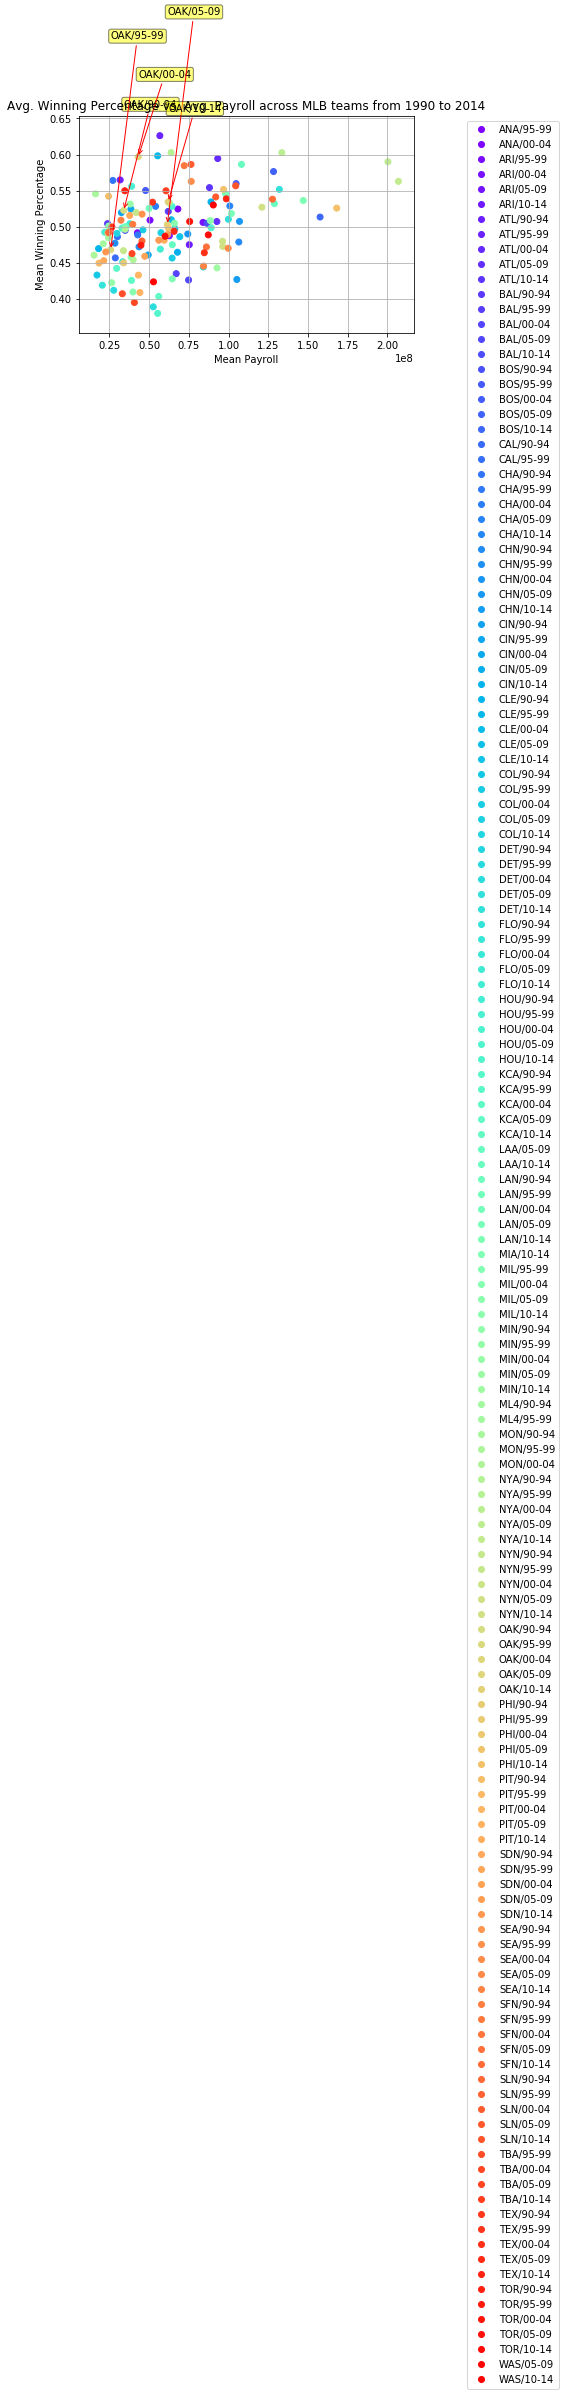

In [68]:
fig6 = plt.figure()

plt.scatter(sumTable2Masked['payrollMean'],sumTable2Masked['winPercMean'],
            c=sumTable2Masked['legendLabels'].map(colorDict2))
legendhandle2 = [plt.plot([], marker="o", ls="", 
                         color=color)[0] for color in list(colorDict2.values())]
plt.legend(legendhandle2,list(colorDict2.keys()),loc="upper right", frameon=True,
          bbox_to_anchor=(1.45, 1.0))
plt.title("Avg. Winning Percentage vs. Avg. Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Mean Payroll")
plt.ylabel("Mean Winning Percentage")

#plt.plot(oak['payrollMean'], p(oak['payrollMean']), color="green", 
#         linewidth=0.5, linestyle="--")

for payroll, winperc, label in oakcoord:
    plt.annotate(label,xy=(payroll, winperc),xytext=(payroll, winperc+random.random()/3),
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            #horizontalalignment='left',verticalalignment='top',color='red',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.', 
            color='red'))
plt.grid()
plt.show()

#### Question 2

**2.1.** What can you say about team payrolls across these periods? 

**Ric wrote:** From Fig3 it can be seen that, when taking the average of the whole MLB, the team payrolls went up

**2.2.** Are there any teams that standout as being particularly good at paying for wins across these time periods? 

**Ric wrote:** Fig5 shows that Cleveland Indians [95-99], New York Yankees [95-99], Atlanta Braves[95-99], and Oakland Atlhletics [00-04] standout

**2.3.** What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

**Ric wrote:** From Fig6 it can be seen that Oakland improved its winning percentage in three consecutive periods reaching a peak in the peeriod between 2000 and 2004. Then its winning percentage went down. In the period when the winning percentage went down for Oakland there was an increase in payroll, unless this increase is due to inflation, this shift is contrary to the philosophy of moneyball. They were not able to identify underrated baseball players and were even willing to pay more for players during this time. 

### Part 3: Data transformations

#### Standardizing across years

It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

#### Problem 5

Create a new variable in your dataset that standardizes payroll conditioned on year. So, this column for team i in year j should equal:

$$
standardizedPayroll_{ij} = \frac{payroll_{ij} - avgPayroll_j}{s_j}
$$

for team i in year j.

where avg_payrollj is the average payroll for year j, and sj is the standard deviation of payroll for year j.

In [69]:
payrollDiscr2 = part1_90to14.groupby('yearCut', as_index=False)['payroll'].agg([list, 'mean'])
payrollDiscr2.columns = ['payrollObs', 'payrollMean']
payrollDiscr2['payrollStd'] = np.nan
for i in range(len(payrollDiscr2)):
    payrollDiscr2.iloc[i,2] = np.std(payrollDiscr2.iloc[i,0])
payrollDiscr2

,payrollObs,payrollMean,payrollStd
yearCut,,,
90-94,"[14555501.0, 9680084.0, 20558333.0, 21720000.0...",2.755261e+07,9.832266e+06
95-99,"[47235445.0, 43942521.0, 32455518.0, 31223171....",4.033507e+07,1.542464e+07
00-04,"[51464167.0, 81027833.0, 84537836.0, 81447435....",6.566536e+07,2.671299e+07
05-09,"[62329166.0, 86457302.0, 73914333.0, 123505125...",8.224307e+07,3.447314e+07
10-14,"[60718166.0, 84423666.0, 81612500.0, 162447333...",9.776966e+07,4.131976e+07


**Ric wrote:** It is my habit to make copies of dataframes used in other questions. That way it is easier to isolate bugs to each part of the homework.

In [70]:
sumTable2Masked2 = sumTable2Masked.copy()

In [71]:
sumTable2Masked2['standarizedPRoll'] = np.nan
sumTable2Masked2.head(5)

payrollMean  winPercMean legendLabels  standarizedPRoll
teamID yearCut                                                         
ANA    95-99     42601546.0     0.491770    ANA/95-99               NaN
       00-04     68057467.0     0.524691    ANA/00-04               NaN
ARI    95-99     50525499.5     0.509259    ARI/95-99               NaN
       00-04     83873716.2     0.506173    ARI/00-04               NaN
       05-09     62679863.2     0.487654    ARI/05-09               NaN

**Ric wrote:** This is a test of how I am going to search for the mean and standard deviation in the payrollDicr2 table while looping on the sumTableMasked2 dataframe to calculate the standardizeddPRoll value for each row. The for loop o populate that column follows.

In [72]:
payrollDiscr2.loc[sumTable2Masked2.index[0][1]][1] #mean
payrollDiscr2.loc[sumTable2Masked2.index[0][1]][2] #std

15424643.049398392

In [73]:
for i in range(len(sumTable2Masked2)):
    sumTable2Masked2.iloc[i,3] = (sumTable2Masked2.iloc[i,0]-payrollDiscr2.loc[sumTable2Masked2.index[i][1]][1])/(payrollDiscr2.loc[sumTable2Masked2.index[0][1]][2]) 

In [74]:
sumTable2Masked2.head(5)

payrollMean  winPercMean legendLabels  standarizedPRoll
teamID yearCut                                                         
ANA    95-99     42601546.0     0.491770    ANA/95-99          0.146938
       00-04     68057467.0     0.524691    ANA/00-04          0.155083
ARI    95-99     50525499.5     0.509259    ARI/95-99          0.660659
       00-04     83873716.2     0.506173    ARI/00-04          1.180472
       05-09     62679863.2     0.487654    ARI/05-09         -1.268309

#### Problem 6

Repeat the same plots as Problem 4, but use this new standardized payroll variable.

#### Question 3

Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.

**Ric wrote:** I am commenting out part of the code. Since this code was useful before I am not completely discarding those lines of code.

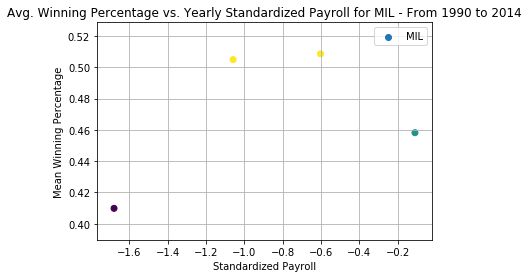

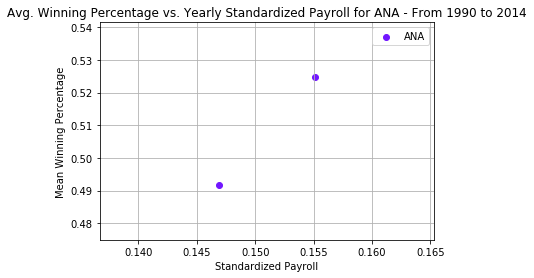

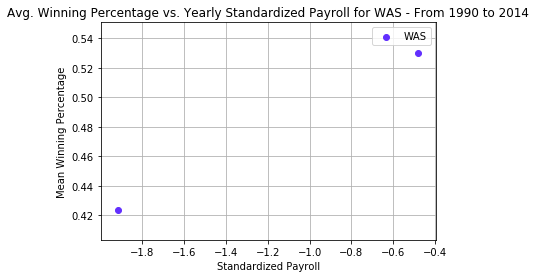

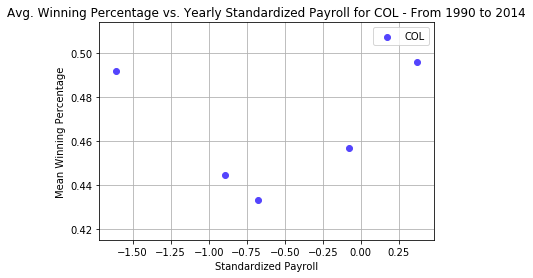

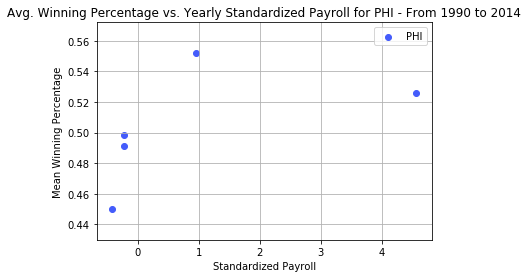

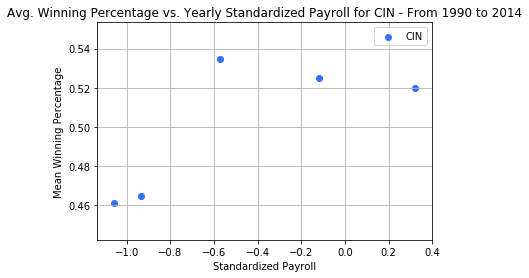

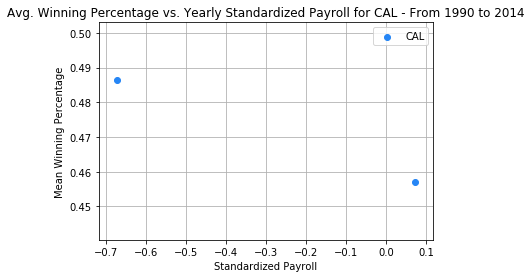

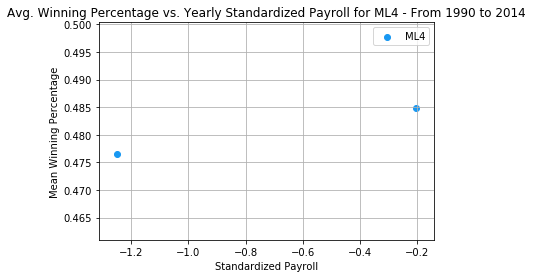

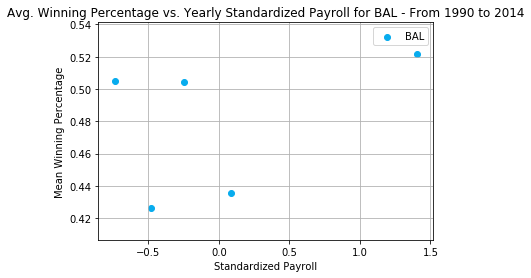

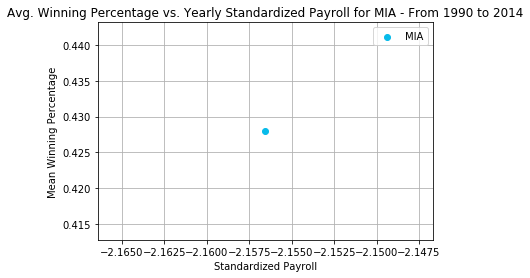

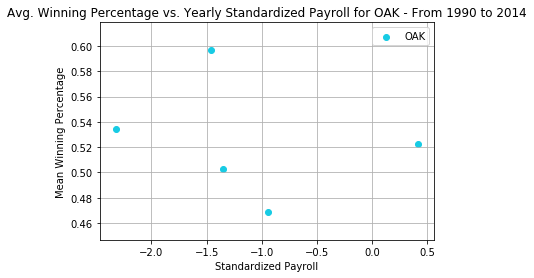

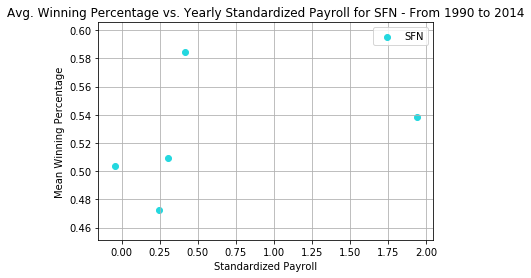

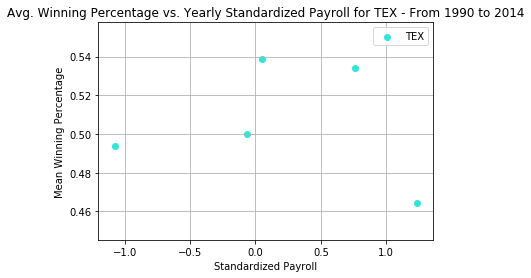

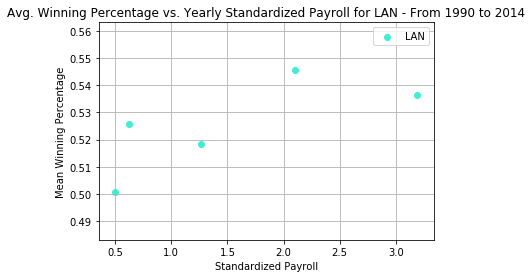

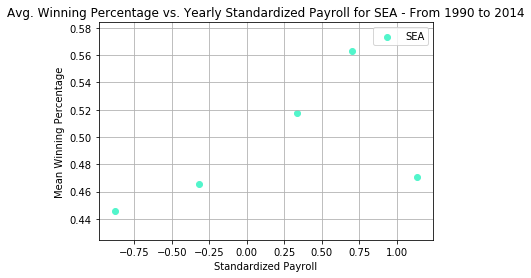

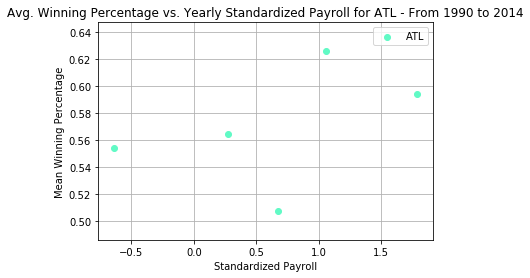

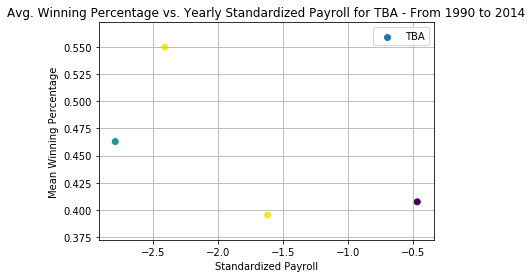

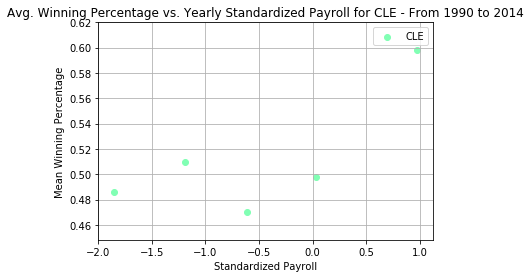

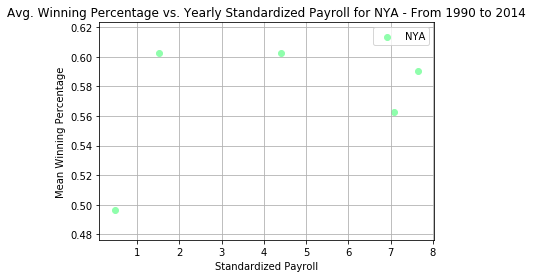

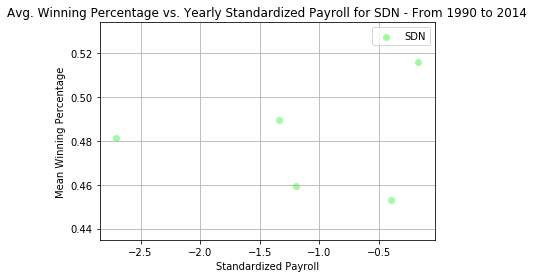

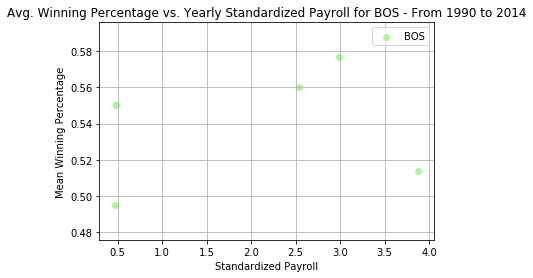

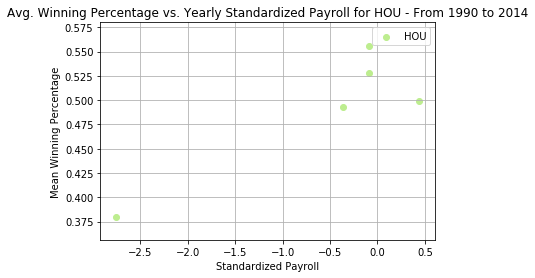

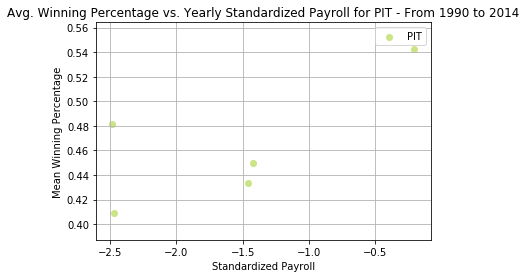

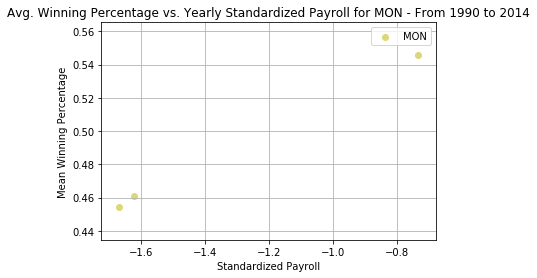

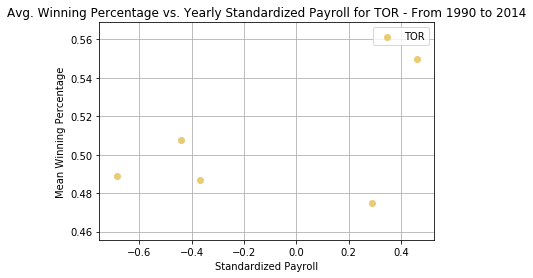

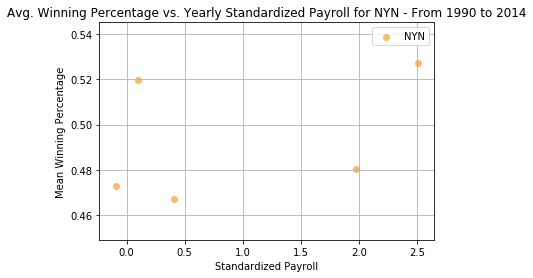

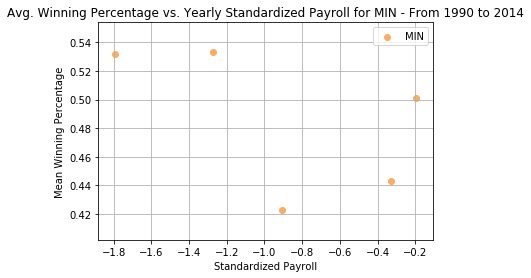

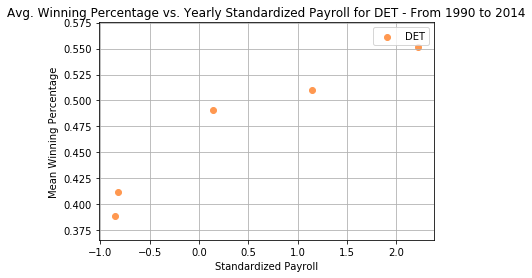

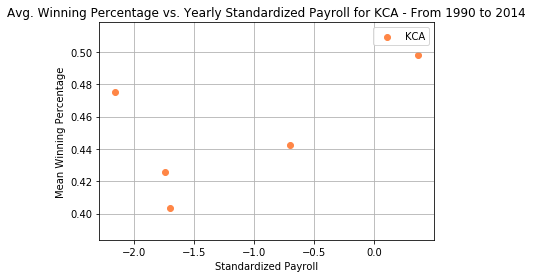

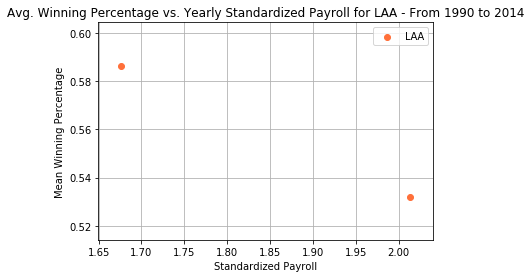

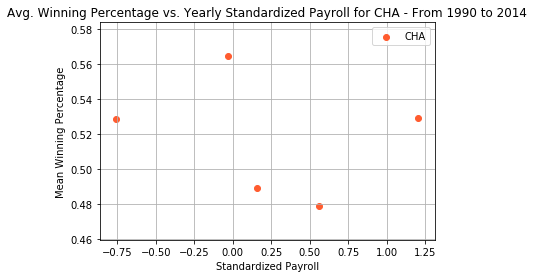

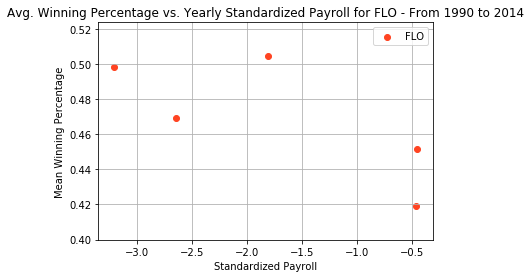

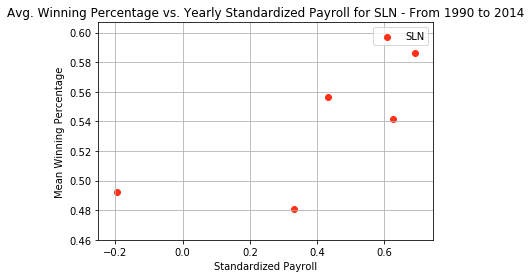

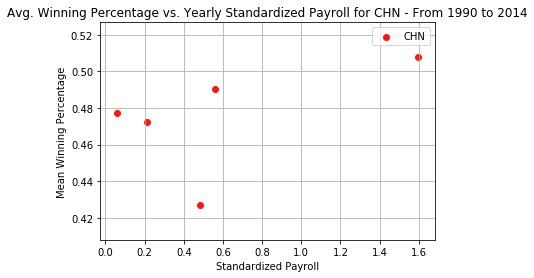

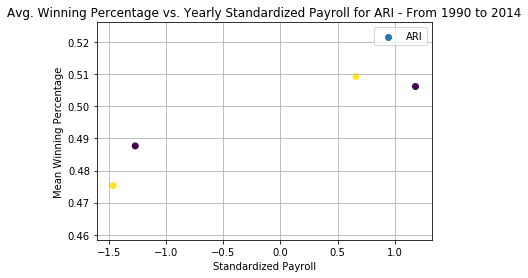

In [75]:
for i in range(len(uniqueTeams)):
#    zz = np.polyfit(sumTable2Masked.loc[uniqueTeams[i]]['payrollMean'].values,
#                sumTable2Masked.loc[uniqueTeams[i]]['winPercMean'].values,1)
#    pp = np.poly1d(zz)

    plt.scatter(sumTable2Masked2.loc[uniqueTeams[i]]['standarizedPRoll'],
            sumTable2Masked2.loc[uniqueTeams[i]]['winPercMean'],
            c=colorS[i],label=uniqueTeams[i])
#         plt.plot(sumTable2Masked.loc[uniqueTeams[i]]['payrollMean'].values, 
#         p(sumTable2Masked.loc[uniqueTeams[i]]['payrollMean'].values),
#         color=colorS[i], 
#         linewidth=0.5, linestyle="-")
    plt.legend()
    plt.title("Avg. Winning Percentage vs. Yearly Standardized Payroll for {} - From 1990 to 2014".format(uniqueTeams[i]))
    plt.xlabel("Standardized Payroll")
    plt.ylabel("Mean Winning Percentage")
    plt.grid()
    plt.show()

**Ric wrote:** I am going to replicate the top five as well as the Oakland annotations I did in the previous part.

In [76]:
top5 = sumTable2Masked2.sort_values(by=['winPercMean'],ascending=False).head(5)
top5

payrollMean  winPercMean legendLabels  standarizedPRoll
teamID yearCut                                                         
ATL    95-99     56707689.0     0.626235    ATL/95-99          1.061458
NYA    95-99     63769882.8     0.602793    NYA/95-99          1.519310
       00-04    133499550.0     0.602655    NYA/00-04          4.397780
CLE    95-99     55325256.6     0.598332    CLE/95-99          0.971833
OAK    00-04     43094550.2     0.596994    OAK/00-04         -1.463295

In [77]:
top5coord = zip(top5['standarizedPRoll'].values,top5['winPercMean'].values,top5['legendLabels'].values)
top5coord

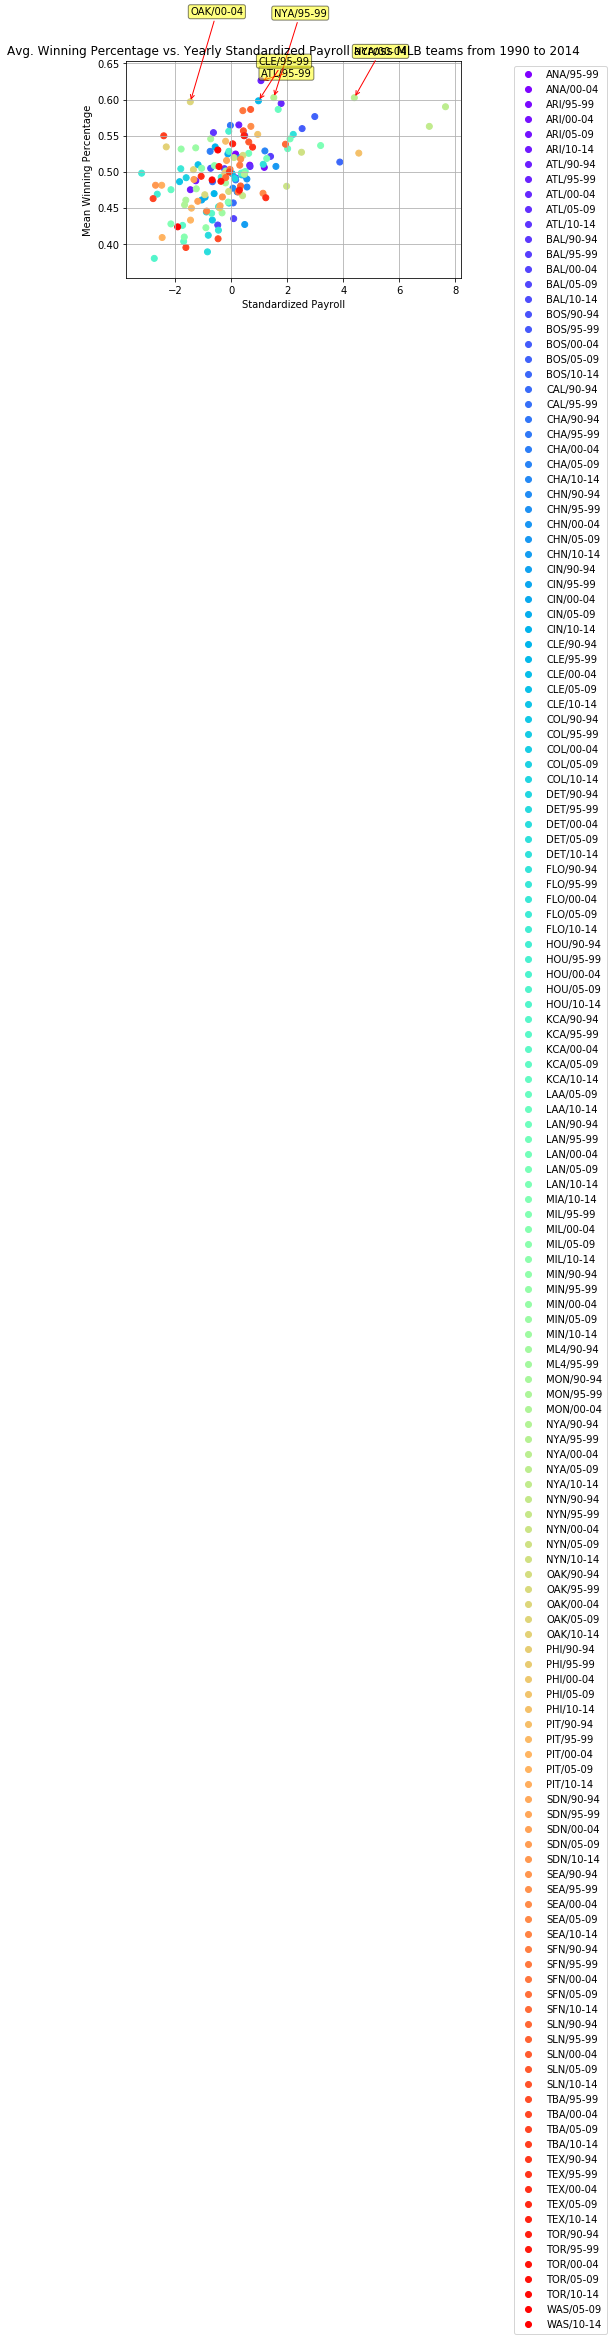

In [78]:
fig7 = plt.figure()

plt.scatter(sumTable2Masked2['standarizedPRoll'],sumTable2Masked2['winPercMean'],
            c=sumTable2Masked2['legendLabels'].map(colorDict2))
legendhandle2 = [plt.plot([], marker="o", ls="", 
                         color=color)[0] for color in list(colorDict2.values())]
plt.legend(legendhandle2,list(colorDict2.keys()),loc="upper right", frameon=True,
          bbox_to_anchor=(1.45, 1.0))
plt.title("Avg. Winning Percentage vs. Yearly Standardized Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Standardized Payroll")
plt.ylabel("Mean Winning Percentage")

for payroll, winperc, label in top5coord:
    plt.annotate(label,xy=(payroll, winperc),xytext=(payroll, winperc+random.random()/7),
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            #horizontalalignment='left',verticalalignment='top',color='red',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.', 
            color='red'))
plt.grid()
plt.show()

**Ric wrote:** In this version of the plot we can better vizualize the effectiveness of teams in their payroll compared to the rest of the MLB teams. For instance, in the top 5 positions (annotated above) we can see that four out of the five are to the left of the 0 in the 'x' axis. This means that these teams had a payroll higher than the rest of the teams. The only one that is at the left of zero in the 'x' axis is Oakland in the years 2000 to 2004. This means that in those years Oakland was being effecting at winning while having a payroll that was less than the average of the payroll of all MLB teams for that time period.

In [79]:
oak = sumTable2Masked2.loc[('OAK')]
oak

,payrollMean,winPercMean,legendLabels,standarizedPRoll
yearCut,,,,
90-94,33981300.2,0.522807,OAK/90-94,0.416781
95-99,25747111.6,0.468364,OAK/95-99,-0.945757
00-04,43094550.2,0.596994,OAK/00-04,-1.463295
05-09,61382581.4,0.503044,OAK/05-09,-1.352413
10-14,61940960.0,0.534568,OAK/10-14,-2.322822


In [80]:
oakcoord = zip(oak['standarizedPRoll'].values,oak['winPercMean'].values,oak['legendLabels'].values)
oakcoord

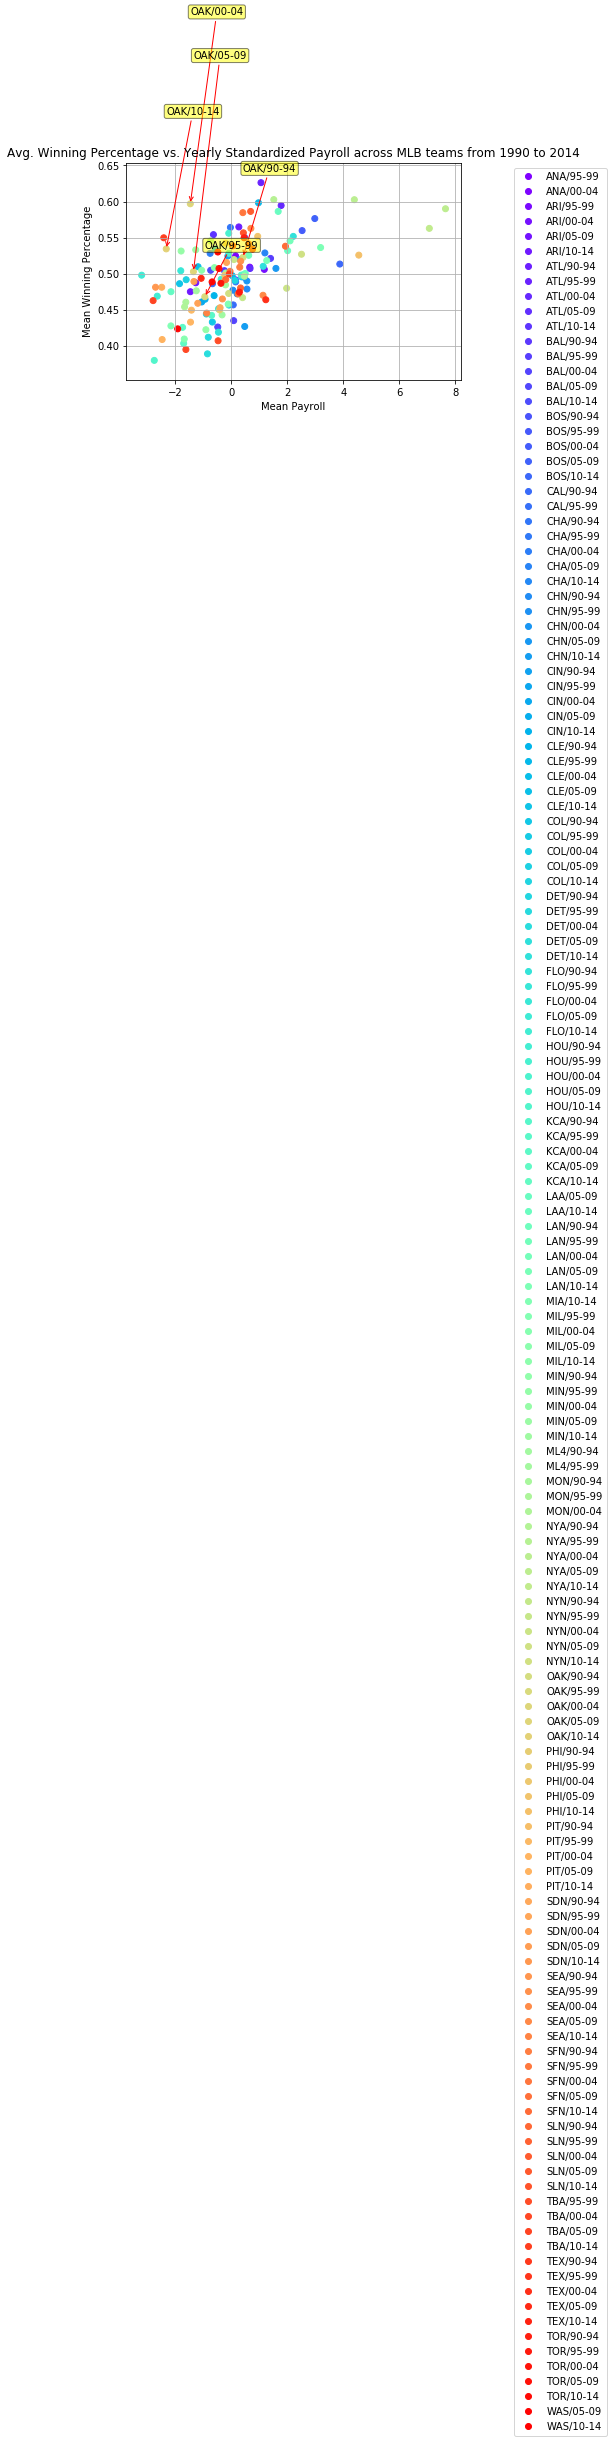

In [81]:
fig8 = plt.figure()

plt.scatter(sumTable2Masked2['standarizedPRoll'],sumTable2Masked2['winPercMean'],
            c=sumTable2Masked2['legendLabels'].map(colorDict2))
legendhandle2 = [plt.plot([], marker="o", ls="", 
                         color=color)[0] for color in list(colorDict2.values())]
plt.legend(legendhandle2,list(colorDict2.keys()),loc="upper right", frameon=True,
          bbox_to_anchor=(1.45, 1.0))
plt.title("Avg. Winning Percentage vs. Yearly Standardized Payroll across MLB teams from 1990 to 2014")
plt.xlabel("Mean Payroll")
plt.ylabel("Mean Winning Percentage")

#plt.plot(oak['payrollMean'], p(oak['payrollMean']), color="green", 
#         linewidth=0.5, linestyle="--")

for payroll, winperc, label in oakcoord:
    plt.annotate(label,xy=(payroll, winperc),xytext=(payroll, winperc+random.random()/3),
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            #horizontalalignment='left',verticalalignment='top',color='red',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.', 
            color='red'))
plt.grid()
plt.show()

**Ric wrote:** From Fig8 it can be seen that once Oakland started improving in getting more efficient with it's payroll it has consistently being below the average of MLB teams in payroll spending.

#### Expected wins

It's hard to see global trends across time periods using these multiple plots, but now that we have standardized payrolls across time, we can look at a single plot showing correlation between winning percentage and payroll across time.

#### Problem 7

Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

In [82]:
z3 = np.polyfit(sumTable2Masked2['standarizedPRoll'],sumTable2Masked2['winPercMean'],1)
p3 = np.poly1d(z3)

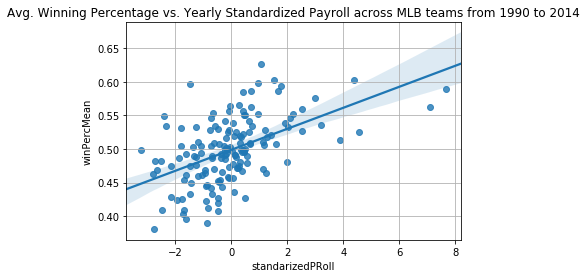

In [99]:
fig8 = sns.regplot(x='standarizedPRoll',y='winPercMean',data=sumTable2Masked2)
plt.title('Avg. Winning Percentage vs. Yearly Standardized Payroll across MLB teams from 1990 to 2014')
plt.grid()

**Ric wrote:** Again, I used seaborn to insert the trend line. 

The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll is 2). We will see how this is done in general using linear regression later in the course.

From these observations we can calculate the expected win percentage for team i in year j as

$$
expectedWinPct_{ij} = 50 + 2.5*standardizedPayroll_{ij}
$$

#### Spending efficiency

Using this result, we can now create a single plot that makes it easier to compare teams efficiency. The idea is to create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.

#### Problem 8

Create a new field to compute each team's spending effiency, given by

$$
efficiency_{ij}  = winPct_{ij} - expectedWinPct_{ij}
$$

Make a line plot with year on the x-axis and efficiency on the y-axis. A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay (teamIDs OAK, BOS, NYA, ATL, TBA).

**Ric wrote:** Since it is not clear if the requirement is over the discretized years or the original yearly data I will attempt this task with both

In [122]:
sumTable2Masked3 = sumTable2Masked2.copy()

In [123]:
sumTable2Masked3['expectedWinPct'] = np.nan
sumTable2Masked3['efficiency'] = np.nan
sumTable2Masked3.head(5)

payrollMean  winPercMean legendLabels  standarizedPRoll  \
teamID yearCut                                                            
ANA    95-99     42601546.0     0.491770    ANA/95-99          0.146938   
       00-04     68057467.0     0.524691    ANA/00-04          0.155083   
ARI    95-99     50525499.5     0.509259    ARI/95-99          0.660659   
       00-04     83873716.2     0.506173    ARI/00-04          1.180472   
       05-09     62679863.2     0.487654    ARI/05-09         -1.268309   

                expectedWinPct  efficiency  
teamID yearCut                              
ANA    95-99               NaN         NaN  
       00-04               NaN         NaN  
ARI    95-99               NaN         NaN  
       00-04               NaN         NaN  
       05-09               NaN         NaN

In [126]:
for i in range(len(sumTable2Masked3)):
    sumTable2Masked3.iloc[i,4] = 50 + 2.5*sumTable2Masked3.iloc[i,3]
    sumTable2Masked3.iloc[i,5] = sumTable2Masked3.iloc[i,1] - sumTable2Masked3.iloc[i,4]
sumTable2Masked3.head(10)

payrollMean  winPercMean legendLabels  standarizedPRoll  \
teamID yearCut                                                            
ANA    95-99     42601546.0     0.491770    ANA/95-99          0.146938   
       00-04     68057467.0     0.524691    ANA/00-04          0.155083   
ARI    95-99     50525499.5     0.509259    ARI/95-99          0.660659   
       00-04     83873716.2     0.506173    ARI/00-04          1.180472   
       05-09     62679863.2     0.487654    ARI/05-09         -1.268309   
       10-14     75231266.4     0.475309    ARI/10-14         -1.461194   
ATL    90-94     31721852.8     0.564977    ATL/90-94          0.270298   
       95-99     56707689.0     0.626235    ATL/95-99          1.061458   
       00-04     93154107.2     0.594602    ATL/00-04          1.782132   
       05-09     92599372.0     0.507407    ATL/05-09          0.671413   

                expectedWinPct  efficiency  
teamID yearCut                              
ANA    95-99         50.367346  -49.875577  
       00-04         50.387709  -49.863017  
ARI    95-99         51.651647  -51.142388  
       00-04         52.951180  -52.445007  
       05-09         46.829228  -46.341574  
       10-14         46.347015  -45.871706  
ATL    90-94         50.675744  -50.110767  
       95-99         52.653646  -52.027411  
       00-04         54.455330  -53.860728  
       05-09         51.678532  -51.171124

In [124]:
payrollDiscr3mean = part3_90to14.groupby('yearID', as_index=False)['payroll'].agg([list, 'mean'])
payrollDiscr3std = part3_90to14.groupby('yearID', as_index=False)['payroll'].agg([list, 'std'])
payrollDiscr3mean.head(3)

,list,mean
yearID,,
1990,"[14555501.0, 9680084.0, 20558333.0, 21720000.0...",1.707235e+07
1991,"[18403500.0, 17519000.0, 35167500.0, 33060001....",2.357879e+07
1992,"[34625333.0, 23780667.0, 43610584.0, 34749334....",3.098244e+07


In [125]:
payrollDiscr3std.head(3)

,list,std
yearID,,
1990,"[14555501.0, 9680084.0, 20558333.0, 21720000.0...",3.771834e+06
1991,"[18403500.0, 17519000.0, 35167500.0, 33060001....",6.894669e+06
1992,"[34625333.0, 23780667.0, 43610584.0, 34749334....",9.150607e+06


In [127]:
part3_90to14 = part1_90to14.copy() 
part3_90to14['standarizedPRoll'] = np.nan
part3_90to14['expectedWinPct'] = np.nan
part3_90to14['efficiency'] = np.nan
part3_90to14.head(5)

,yearID,teamID,payroll,winPerc,yearCut,standarizedPRoll,expectedWinPct,efficiency
130,1990,ATL,14555501.0,0.401235,90-94,NaN,NaN,NaN
131,1990,BAL,9680084.0,0.472050,90-94,NaN,NaN,NaN
132,1990,BOS,20558333.0,0.543210,90-94,NaN,NaN,NaN
133,1990,CAL,21720000.0,0.493827,90-94,NaN,NaN,NaN
134,1990,CHA,9491500.0,0.580247,90-94,NaN,NaN,NaN


In [131]:
for i in range(len(part3_90to14)):
    tempIndx = part3_90to14.iloc[i,0]
    part3_90to14.iloc[i,5] = (part3_90to14.iloc[i,2]-payrollDiscr3mean.loc[tempIndx][1])/(payrollDiscr3std.loc[tempIndx][1])
    part3_90to14.iloc[i,6] = 50 + 2.5*part3_90to14.iloc[i,5]
    part3_90to14.iloc[i,7] = part3_90to14.iloc[i,3] - part3_90to14.iloc[i,6] 

In [132]:
part3_90to14.head(5)

,yearID,teamID,payroll,winPerc,yearCut,standarizedPRoll,expectedWinPct,efficiency
130,1990,ATL,14555501.0,0.401235,90-94,-0.667275,48.331811,-47.930577
131,1990,BAL,9680084.0,0.472050,90-94,-1.959861,45.100348,-44.628299
132,1990,BOS,20558333.0,0.543210,90-94,0.924213,52.310533,-51.767323
133,1990,CAL,21720000.0,0.493827,90-94,1.232198,53.080495,-52.586668
134,1990,CHA,9491500.0,0.580247,90-94,-2.009859,44.975353,-44.395107


**Ric wrote:** I'm adding Cleveland Indians to the list suggested by the homework. This is because I found it a notable team in thee plots above.

In [143]:
teamLabels2 = ['OAK','BOS','NYA','ATL','TBA','CLE']

**Ric wrote:** I am starting with the discretized-by-five-year-periods data

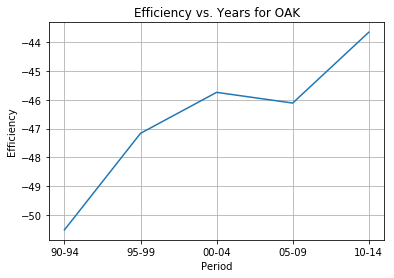

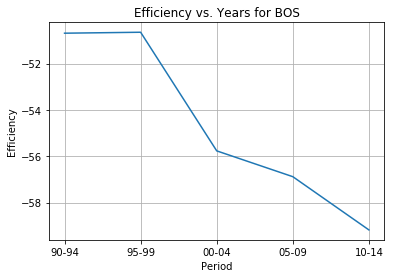

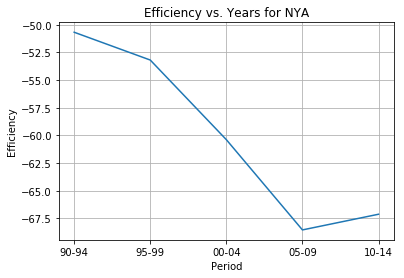

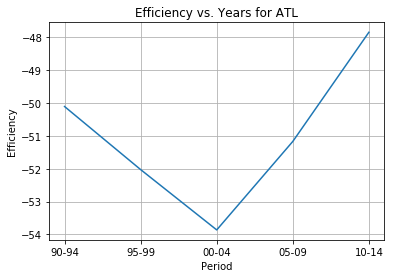

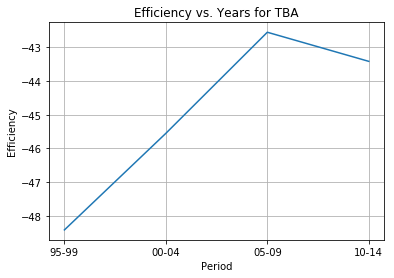

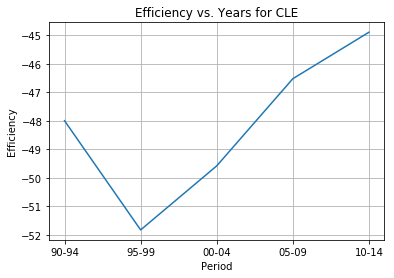

In [157]:
for team in teamLabels2:
    plt.plot(list(sumTable2Masked3.loc[team].index.values),sumTable2Masked3.loc[team]['efficiency'].values)
    plt.title('Efficiency vs. Years for {}'.format(team))
    plt.xlabel('Period')
    plt.ylabel('Efficiency')
    plt.grid()
    plt.show()

**Ric wrote:** Now I am going to try with the un-discretized dataset

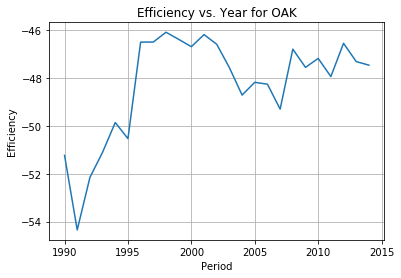

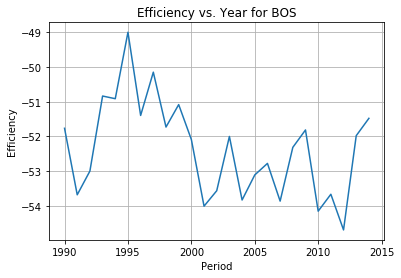

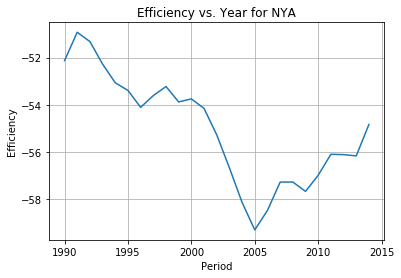

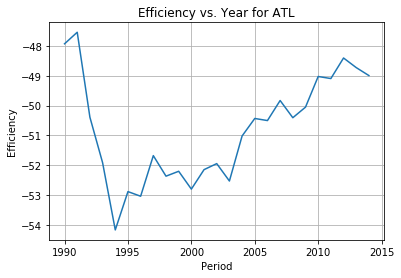

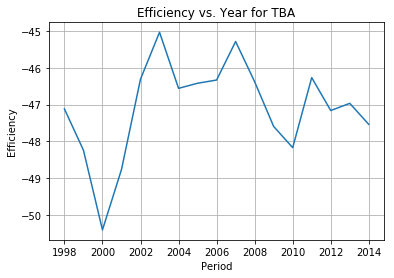

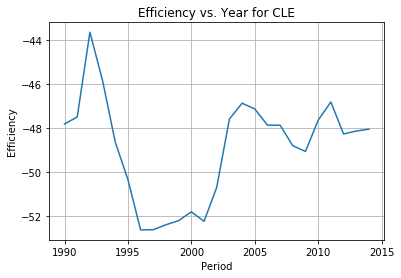

In [156]:
for team in teamLabels2:
    plt.plot(part3_90to14[part3_90to14['teamID']==team]['yearID'],
         part3_90to14[part3_90to14['teamID']==team]['efficiency'].values)
    plt.title('Efficiency vs. Year for {}'.format(team))
    plt.xlabel('Period')
    plt.ylabel('Efficiency')
    plt.grid()
    plt.show()

#### Question 4

* 4.1. What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? 

**Ric wrote:** The efficiency of New York Yankees and Atlanta Braves was very high in the early 90s whereas the efficiency of Oakland was low at this time. The efficiency of Boston goes up and down over the years (when seeing the yearly plot. In the five-year time periods it just goes down). The efficiency of Cleveland is high on the early 90s then it comes down and it recovers starting on the mid 2000s

* 4.2. How good was Oakland's efficiency during the Moneyball period?

**Ric wrote:** The efficiency of Oakland peaks around the Moneyball period. It is high by the specific season of the movie 2002. Note however that  the peak started around 1996-1997. Billy Beane (the protagonist of Moneyball was promoted to GM after 1997. It seems that Billy Beane's promotion is at least correlated with the efficiency peak.